In [3]:
# to visualize the dataset(e.g.Zara-01): cd into UCY_ETH_Visualization and run python utils.py

In [1]:
import csv
import os
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import networkx as nx
from Social_STGCNN.utils import *
from Social_STGCNN.metrics import *
import pickle
import glob
import copy
import torch.distributions.multivariate_normal as torchdist
from torchsummaryX import summary
import pandas as pd
pd.set_option('display.max_rows', 500)
from tqdm import tqdm, trange

In [2]:
# GCN class: 
# input: graph formulations G_t1...G_t8
# output: node embedding 

# GRU class: 
# input: node embedding from GCN for this time step AND GRU output from last time step 
# output:  mean_x, mean_y,variance_x,variance_y and correlation_xy (dim 5)

In [3]:
# build model
# source: https://github.com/meliketoy/graph-cnn.pytorch/blob/master/layers.py

class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True, init='xavier'):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        if init == 'uniform':
            print("| Uniform Initialization")
            self.reset_parameters_uniform()
        elif init == 'xavier':
            print("| Xavier Initialization")
            self.reset_parameters_xavier()
        elif init == 'kaiming':
            print("| Kaiming Initialization")
            self.reset_parameters_kaiming()
        else:
            raise NotImplementedError

    def reset_parameters_uniform(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def reset_parameters_xavier(self):
        nn.init.xavier_normal_(self.weight.data, gain=0.02) # Implement Xavier Uniform
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)

    def reset_parameters_kaiming(self):
        nn.init.kaiming_normal_(self.weight.data, a=0, mode='fan_in')
        if self.bias is not None:
            nn.init.constant_(self.bias.data, 0.0)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.weight)
#         output = torch.spmm(adj, Wh)
        output = torch.mm(adj,Wh)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'
    
class GCN(nn.Module):
    def __init__(self, nlayers, nfeat, nhid, nclass, dropout, bias = False, init='xavier'):
        super(GCN, self).__init__()
        # 魔改
        self.gc1 = GraphConvolution(nfeat, nclass, init=init)
#         self.gc2 = GraphConvolution(64, nclass, init=init)
#         self.gc3 = GraphConvolution(128, nclass, init=init)
        self.dropout = dropout
        self.lrelu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

#     def bottleneck(self, path1, path2, path3, adj, in_x):
#         return F.relu(path3(F.relu(path2(F.relu(path1(in_x, adj)), adj)), adj))

    def forward(self, x, adj):
        return self.gc1(x, adj)
#         x = F.dropout(self.sigmoid(self.gc1(x, adj)), self.dropout, training=self.training)
#         return self.sigmoid(self.gc2(x,adj))
#         x = F.dropout(self.lrelu(self.gc2(x, adj)), self.dropout, training=self.training)
#         return self.lrelu(self.gc2(x, adj))
#         return F.log_softmax(x, dim=1)
#     def __init__(self,nlayers, nfeat, nhid, nclass, dropout, init='xavier',seq_len=8):
#         super(GCN, self).__init__()
#         # 魔改
#         self.nfeat = nfeat
#         self.nembedded=nclass
# #             self.gc_enc1 = GraphConvolution(nfeat, nclass, init=init)
# #         self.gc_enc2 = GraphConvolution(4, nclass, init=init)
# #         self.gc_enc3 = GraphConvolution(2, nclass, init=init)
#         self.gc_dec1 = GraphConvolution(nclass, 2, init=init)
# #         self.gc_dec2 = GraphConvolution(8, 4, init=init)
# #             self.gc_dec3 = GraphConvolution(nclass, nfeat, init=init)
# #             self.dropout = dropout
# #             self.lrelu = nn.LeakyReLU(0.2)
# #             self.tanh = nn.Tanh()
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, Vt, At):
#         D = torch.sum(At,dim=0)
#         D_inv = torch.diag(D**-0.5)
#         A_hat = torch.mm(torch.mm(D_inv,At), D_inv)
#         ######## ~0.02 MSE, nclass= 2,lr0.001 #######
#         return self.sigmoid(self.gc_dec1(Vt,A_hat))
# #         encoded=decoded

######### i wrote this #######
class GCNandGRU(nn.Module):
    def __init__(self, device, num_gcn_layers, num_gru_layers, num_node_feat, num_hid_gcn, num_hid_gru, num_embedded_features, gcn_dropout, gru_dropout, init='xavier',
                 seq_len=8,pred_seq_len=12):
        super(GCNandGRU, self).__init__()
        self.num_embedded_features=num_embedded_features
        self.seq_len = seq_len
        self.pred_seq_len = pred_seq_len
        self.num_hid_gru = num_hid_gru
#         self.gcns = nn.ModuleList([GCN(num_gcn_layers, num_node_feat, num_hid_gcn, num_embedded_features, gcn_dropout, init) for _ in range(seq_len)])
        self.gcn = GCN(num_gcn_layers, num_node_feat, num_hid_gcn, num_embedded_features, gcn_dropout, init)
        self.grucell = nn.GRUCell(num_embedded_features, num_hid_gru)
#         self.seq_gru = nn.ModuleList([nn.GRUCell(num_embedded_features, num_hid_gru) for _ in range(seq_len)])
#         self.pred_gru = nn.ModuleList([nn.GRUCell(num_embedded_features, num_hid_gru) for _ in range(pred_seq_len)])
        self.linear = nn.Linear(num_hid_gru, num_embedded_features)
#         self.pred_gru_linears = nn.ModuleList([nn.Linear(num_hid_gru, num_embedded_features) for _ in range(pred_seq_len)])
        self.lrelu = nn.LeakyReLU()
        self.linear_final = nn.Linear(num_hid_gru, 5)
#         self.final_linears = nn.ModuleList([nn.Linear(num_hid_gru, 5) for _ in range(pred_seq_len)])
    def forward(self, V,A): 
        """
        V, A are tensors stacked (e.g.V_t1...V_tn) 
        with shape (batch size, seq_len, num_nodes, 2 or num_nodes)
                
        returns: output, h_n
            output is of shape (seq_len, num_nodes, num_hid_gru)
            h_n is of shape (num_layers, num_nodes, num_hid_gru)
        TODO: naive implementation only allows batch size 1 b/c of adj matrix
            items in a batch is computed one by one
            1) idk how to make gcn work for batch except for looping 
            2) in gru i have to treat num_nodes as batch demension since gru input has to be (batch, input_size)
        """ 
        batch_size, _, num_nodes, _ = V.shape # batch size is always 1 
        ########### First try old GRU ############
#         gru_input_seq = torch.zeros((self.seq_len, num_nodes, self.num_embedded_features)) # we're treating as if each node/pedestrian is a single sample in a batch.
#         for batch_indx in range(batch_size): # batch size is 1. dunno what to do for more
#             for t in range(self.seq_len): 
#                 Vt = V[batch_indx,t,:,:] # shape: (num_nodes, D=2)
#                 At = A[batch_indx,t,:,:] # shape: (num_nodes, num_nodes)
#                 gcn_out = self.gcn(Vt, At) # shape: (num_nodes, num_embedded)
#                 gru_input_seq[t, :, :] = gcn_out # TODO: doensn't work for batch size > 1
#         return self.gru(gru_input_seq) # input shape (seq_len, num_nodes, num_embedded_features)
        ################################
        out = torch.zeros(batch_size, self.pred_seq_len, num_nodes, 5).to(device)
        for batch_indx in range(batch_size): 
            for t in range(self.seq_len):
                Vt = V[batch_indx,t,:,:] # shape: (num_nodes, D=2)
                At = A[batch_indx,t,:,:] # shape: (num_nodes, num_nodes)
                gcn_out = self.gcn(Vt, At) # shape: (num_nodes, num_embedded)
                if t == 0:
                    ht = self.grucell(gcn_out)
                else:
                    ht = self.grucell(gcn_out, ht) # shape: (num_nodes, num_hid_gru)
            for t in range(self.pred_seq_len): 
                xt = self.lrelu(self.linear(ht))
                ht = self.grucell(xt, ht) # shape: (num_nodes, num_hid_gru)
                out[batch_indx, t, :, :] = self.linear_final(ht) # shape: (num_nodes, 5)
#         for batch_indx in range(batch_size): 
#             for t in range(self.seq_len):
#                 Vt = V[batch_indx,t,:,:] # shape: (num_nodes, D=2)
#                 At = A[batch_indx,t,:,:] # shape: (num_nodes, num_nodes)
#                 gcn_out = self.gcn(Vt, At) # shape: (num_nodes, num_embedded)
#                 if t == 0:
#                     ht = self.seq_gru[t](gcn_out)
#                 else:
#                     ht = self.seq_gru[t](gcn_out, ht) # shape: (num_nodes, num_hid_gru)
#             for t in range(self.pred_seq_len): 
#                 xt = self.lrelu(self.pred_gru_linears[t](ht))
#                 ht = self.pred_gru[t](xt, ht) # shape: (num_nodes, num_hid_gru)
#                 out[batch_indx, t, :, :] = self.final_linears[t](ht) # shape: (num_nodes, 5)
        return out

In [66]:
# training functions
# source: https://github.com/abduallahmohamed/Social-STGCNN/blob/master/train.py

def graph_loss(V_pred,V_target):
    return bivariate_loss(V_pred,V_target)

def train(epoch):
    global metrics,loader_train
    model.train()
    loss_batch = 0 
    batch_count = 0
    is_fst_loss = True
    loader_len = len(loader_train)
    turn_point =int(loader_len/batch_size)*batch_size+ loader_len%batch_size -1


    for cnt,batch in enumerate(loader_train): 
        batch_count+=1

        #Get data
        batch = [tensor.to(device) for tensor in batch]
        obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_ped,\
         loss_mask,V_obs,A_obs,V_tr,A_tr = batch


        optimizer.zero_grad()
        #Forward
        #V_obs = batch,seq,node,feat
        #V_obs_tmp = batch,feat,seq,node
#         V_obs_tmp =V_obs.permute(0,3,1,2)

#         V_pred,_ = model(V_obs_tmp,A_obs.squeeze())
        
#         V_pred = V_pred.permute(0,2,3,1)
        out = model(V_obs,A_obs)
        V_pred = out
#         V_pred = V_pred.permute(2,1,0)

        V_tr = V_tr.squeeze()
        A_tr = A_tr.squeeze()
        V_pred = V_pred.squeeze()
        
#         if batch_count%batch_size !=0 and cnt != turn_point :
        l = graph_loss(V_pred,V_tr)
#         if is_fst_loss :
        loss = l
#             is_fst_loss = False
#         else:
#             loss += l

#         else:
        loss = loss/batch_size
        is_fst_loss = True
        loss.backward()

        optimizer.step()
        #Metrics
        loss_batch += loss.item()
        if print_each_loss:
            print('TRAIN:','\t Epoch:', epoch,'\t Loss:',loss_batch/batch_count)
            
    metrics['train_loss'].append(loss_batch/batch_count)
    

def vald(epoch):
    global metrics,loader_val,constant_metrics
    model.eval()
    loss_batch = 0 
    batch_count = 0
    is_fst_loss = True
    loader_len = len(loader_val)
    turn_point =int(loader_len/batch_size)*batch_size+ loader_len%batch_size -1
    
    for cnt,batch in enumerate(loader_val): 
        batch_count+=1

        #Get data
        batch = [tensor.to(device) for tensor in batch]
        obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_ped,\
         loss_mask,V_obs,A_obs,V_tr,A_tr = batch
        

#         V_obs_tmp =V_obs.permute(0,3,1,2)

#         V_pred,_ = model(V_obs_tmp,A_obs.squeeze())
        
#         V_pred = V_pred.permute(0,2,3,1)
        out = model(V_obs,A_obs)
        V_pred = out
#         V_pred = V_pred.permute(2,1,0)
        
        V_tr = V_tr.squeeze()
        A_tr = A_tr.squeeze()
        V_pred = V_pred.squeeze()
        
#         if batch_count%batch_size !=0 and cnt != turn_point :

        l = graph_loss(V_pred,V_tr)
        
#             if is_fst_loss :
        loss = l
#                 is_fst_loss = False
#             else:
#                 loss += l

#         else:
        loss = loss/batch_size
        is_fst_loss = True
        #Metrics
        loss_batch += loss.item()
        if print_each_loss:
            print('VALD:','\t Epoch:', epoch,'\t Loss:',loss_batch/batch_count)

    metrics['val_loss'].append(loss_batch/batch_count)
    
    if  metrics['val_loss'][-1]< constant_metrics['min_val_loss']:
        constant_metrics['min_val_loss'] =  metrics['val_loss'][-1]
        constant_metrics['min_val_epoch'] = epoch
        torch.save(model.state_dict(),checkpoint_dir+'val_best.pth')  # OK
def test(KSTEPS=20):
    global loader_test,model
    model.eval()
    ade_bigls = []
    fde_bigls = []
    raw_data_dict = {}
    step =0 
    for batch in loader_test: 
        step+=1
        #Get data
        batch = [tensor.to(device) for tensor in batch]
        obs_traj, pred_traj_gt, obs_traj_rel, pred_traj_gt_rel, non_linear_ped,\
         loss_mask,V_obs,A_obs,V_tr,A_tr = batch


        num_of_objs = obs_traj_rel.shape[1]

        #Forward
        #V_obs = batch,seq,node,feat
        #V_obs_tmp = batch,feat,seq,node
        V_obs_tmp =V_obs.permute(0,3,1,2)

#         V_pred,_ = model(V_obs_tmp,A_obs.squeeze())
        out = model(V_obs,A_obs)
        V_pred = out
        # print(V_pred.shape)
        # torch.Size([1, 5, 12, 2])
        # torch.Size([12, 2, 5])
#         V_pred = V_pred.permute(0,2,3,1)
        # torch.Size([1, 12, 2, 5])>>seq,node,feat
        # V_pred= torch.rand_like(V_tr).cuda()


        V_tr = V_tr.squeeze()
        A_tr = A_tr.squeeze()
        V_pred = V_pred.squeeze()
        num_of_objs = obs_traj_rel.shape[1]
        V_pred,V_tr =  V_pred[:,:num_of_objs,:],V_tr[:,:num_of_objs,:]
        #print(V_pred.shape)

        #For now I have my bi-variate parameters 
        #normx =  V_pred[:,:,0:1]
        #normy =  V_pred[:,:,1:2]
        sx = torch.exp(V_pred[:,:,2]) #sx
        sy = torch.exp(V_pred[:,:,3]) #sy
        corr = torch.tanh(V_pred[:,:,4]) #corr
        
        cov = torch.zeros(V_pred.shape[0],V_pred.shape[1],2,2).to(device)
        cov[:,:,0,0]= sx*sx
        cov[:,:,0,1]= corr*sx*sy
        cov[:,:,1,0]= corr*sx*sy
        cov[:,:,1,1]= sy*sy
        mean = V_pred[:,:,0:2]
        
        mvnormal = torchdist.MultivariateNormal(mean,cov)


        ### Rel to abs 
        ##obs_traj.shape = torch.Size([1, 6, 2, 8]) Batch, Ped ID, x|y, Seq Len 
        
        #Now sample 20 samples
        ade_ls = {}
        fde_ls = {}
        V_x = seq_to_nodes(obs_traj.data.cpu().numpy().copy())
        V_x_rel_to_abs = nodes_rel_to_nodes_abs(V_obs.data.cpu().numpy().squeeze().copy(),
                                                 V_x[0,:,:].copy())

        V_y = seq_to_nodes(pred_traj_gt.data.cpu().numpy().copy())
        V_y_rel_to_abs = nodes_rel_to_nodes_abs(V_tr.data.cpu().numpy().squeeze().copy(),
                                                 V_x[-1,:,:].copy())
        
        raw_data_dict[step] = {}
        raw_data_dict[step]['obs'] = copy.deepcopy(V_x_rel_to_abs)
        raw_data_dict[step]['trgt'] = copy.deepcopy(V_y_rel_to_abs)
        raw_data_dict[step]['pred'] = []

        for n in range(num_of_objs):
            ade_ls[n]=[]
            fde_ls[n]=[]

        for k in range(KSTEPS):

            V_pred = mvnormal.sample()



            #V_pred = seq_to_nodes(pred_traj_gt.data.numpy().copy())
            V_pred_rel_to_abs = nodes_rel_to_nodes_abs(V_pred.data.cpu().numpy().squeeze().copy(),
                                                     V_x[-1,:,:].copy())
            raw_data_dict[step]['pred'].append(copy.deepcopy(V_pred_rel_to_abs))
            
           # print(V_pred_rel_to_abs.shape) #(12, 3, 2) = seq, ped, location
            for n in range(num_of_objs):
                pred = [] 
                target = []
                obsrvs = [] 
                number_of = []
                pred.append(V_pred_rel_to_abs[:,n:n+1,:])
                target.append(V_y_rel_to_abs[:,n:n+1,:])
                obsrvs.append(V_x_rel_to_abs[:,n:n+1,:])
                number_of.append(1)
                ade_ls[n].append(ade(pred,target,number_of))
                fde_ls[n].append(fde(pred,target,number_of))
        
        for n in range(num_of_objs):
            ade_bigls.append(min(ade_ls[n]))
            fde_bigls.append(min(fde_ls[n]))

    ade_ = sum(ade_bigls)/len(ade_bigls)
    fde_ = sum(fde_bigls)/len(fde_bigls)
    return ade_,fde_,raw_data_dict

In [11]:
# user needs to change 
tags = ['eth','hotel','univ', 'zara1','zara2']
num_epochs = 150
batch_size = 128
num_hid_gcn = 64 # first layer output dim , no longer used
num_hid_gru = 64
num_embedded_features = 2 # output gcn num feat
lr = 0.1
# lr_sh_rate = 150
lr_patience = 5
gcn_dropout = 0.8
print_each_loss = False
##### don't change ####
obs_seq_len=8 
pred_seq_len=12
gru_dropout = 0.8 # not implemented yet
num_gcn_layers = 2 # not implemented yet
num_gru_layers = 1 # not implemented yet
num_node_feat = 2 # (x,y) so 2. don't change
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [15]:
# hyperparameter search
for tag in tags:
    best_ade = 999999
    # load data
    dataset = './Social_STGCNN/datasets/'+tag+'/'
    checkpoint_dir = './model_checkpoint/'+tag+'/'
    print(tag)
    dset_train = TrajectoryDataset(
        dataset+'train/',
        obs_len=obs_seq_len,
        pred_len=pred_seq_len,
        skip=1,norm_lap_matr=False)

    loader_train = DataLoader(
            dset_train,
            batch_size=1, #This is irrelative to the args batch size parameter
            shuffle =True,
            num_workers=0)


    dset_val = TrajectoryDataset(
            dataset+'val/',
            obs_len=obs_seq_len,
            pred_len=pred_seq_len,
            skip=1,norm_lap_matr=False)

    loader_val = DataLoader(
            dset_val,
            batch_size=1, #This is irrelative to the args batch size parameter
            shuffle =False,
            num_workers=1)
    dset_test = TrajectoryDataset(
                dataset+'test/',
                obs_len=obs_seq_len,
                pred_len=pred_seq_len,
                skip=1,norm_lap_matr=False)

    loader_test = DataLoader(
            dset_test,
            batch_size=1,#This is irrelative to the args batch size parameter
            shuffle =False,
            num_workers=1)
# l = [8,16,32,64,128,256]
# l.reverse()
# best_val_loss = 9999999
# for num_hid_gcn in l:
# for num_hid_gru in [8,16,32,64,128,256]:
# #         for num_embedded_features in [8,16,32,64,128,256]:
#     for gcn_dropout in [0.4,0.8]:
#         for gru_dropout in [0.4,0.8]:
#             print(num_hid_gcn,num_hid_gru,num_embedded_features,gcn_dropout,gru_dropout)
    # training loop 
    model = GCNandGRU(device,
                      num_gcn_layers, 
                      num_gru_layers, 
                      num_node_feat, 
                      num_hid_gcn, 
                      num_hid_gru, 
                      num_embedded_features, 
                      gru_dropout, 
                      gcn_dropout,
                      init='xavier',
                      seq_len=8,
                      pred_seq_len=12).to(device)
    optimizer = optim.SGD(model.parameters(),lr=lr)
    # optimizer = optim.SGD(model.parameters(),lr=lr, weight_decay = 1e-6, momentum = 0.1, nesterov=True)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_sh_rate, gamma=0.2)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2,patience = lr_patience,verbose=True)
    metrics = {'train_loss':[],  'val_loss':[]}
    constant_metrics = {'min_val_epoch':-1, 'min_val_loss':9999999999999999}
    print('Training started ...')
    for epoch in range(num_epochs):
        train(epoch)
        vald(epoch)
        scheduler.step(metrics['train_loss'][epoch])


        print('*'*30)
        print('Epoch:',tag,":", epoch, 'LR: ', optimizer.param_groups[0]['lr'])
        for k,v in metrics.items():
            if len(v)>0:
                print(k,v[-1])


        print(constant_metrics)
        ade_ =999999
        fde_ =999999
        print("Testing ....")
        ad,fd,raw_data_dic_= test()
        ade_= min(ade_,ad)
        fde_ =min(fde_,fd)
        ade_ls.append(ade_)
        fde_ls.append(fde_)
        print("ADE:",ade_," FDE:",fde_)
        if (ade_<best_ade):
            best_ade = ade_
            torch.save(model.state_dict(),checkpoint_dir+'ade_best.pth')
        print('*'*30)

        with open(checkpoint_dir+'metrics.pkl', 'wb') as fp:
            pickle.dump(metrics, fp)

        with open(checkpoint_dir+'constant_metrics.pkl', 'wb') as fp:
            pickle.dump(constant_metrics, fp)
        torch.save(model.state_dict(),checkpoint_dir+'latest.pth')
    print(best_ade)
    #     # for hyperparameter search
    #     if val_loss < best_val_loss: 
    #         print('new best hyperparameters found')
    #         best_val_loss = val_loss
    #         with open('./param_search.txt', 'a') as log: 
    #             log.write('num_hid_gcn='+str(num_hid_gcn)+'\n')
    #             log.write('num_hid_gru='+str(num_hid_gru)+'\n')
    #             log.write('num_embedded_features='+str(num_embedded_features)+'\n')
    #             log.write('gcn_dropout='+str(gcn_dropout)+'\n')
    #             log.write('gru_dropout='+str(gru_dropout)+'\n')
    #             log.write('best_val_loss='+str(val_loss)+' at epoch '+str(epoch))
    #         torch.save(model.state_dict(),'eth_param_search_val_best.pth')


eth


  2%|▏         | 44/2785 [00:00<00:06, 427.34it/s]

Processing Data .....


  3%|▎         | 20/660 [00:00<00:03, 192.08it/s]

Processing Data .....


100%|██████████| 70/70 [00:00<00:00, 601.48it/s]

Processing Data .....
| Xavier Initialization
Training started ...


******************************
Epoch: eth : 0 LR:  0.1
train_loss 0.0002589174339816472
val_loss -0.004300079416428603
{'min_val_epoch': 0, 'min_val_loss': -0.004300079416428603}
Testing ....
ADE: 1.6019118084150972  FDE: 2.9052379387283596
******************************
******************************
Epoch: eth : 1 LR:  0.1
train_loss -0.0036316835616831745
val_loss -0.005767914164043346
{'min_val_epoch': 1, 'min_val_loss': -0.005767914164043346}
Testing ....
ADE: 1.2641005739795501  FDE: 2.1622618292636098
******************************
******************************
Epoch: eth : 2 LR:  0.1
train_loss -0.0046631700230244395
val_loss -0.00631587048491638
{'min_val_epoch': 2, 'min_val_loss': -0.00631587048491638}
Testing ....
ADE: 1.2276710674113802  FDE: 2.0584679224523224
******************************
******************************
Epoch: eth : 3 LR:  0.1
train_loss -0.005442405456321093
val_loss -0.006735956349257321
{'min_val_epoch': 3, 'min_val_loss': -0.006735956349257321}
Testi

ADE: 1.3005055916424053  FDE: 1.9501518535796907
******************************
******************************
Epoch: eth : 31 LR:  0.1
train_loss -0.008489754824032532
val_loss -0.008689050826493865
{'min_val_epoch': 31, 'min_val_loss': -0.008689050826493865}
Testing ....
ADE: 1.3106539964695656  FDE: 1.965783887491997
******************************
******************************
Epoch: eth : 32 LR:  0.1
train_loss -0.00850064383654168
val_loss -0.008174614832751104
{'min_val_epoch': 31, 'min_val_loss': -0.008689050826493865}
Testing ....
ADE: 1.3627982045374385  FDE: 2.0614547442989988
******************************
******************************
Epoch: eth : 33 LR:  0.1
train_loss -0.008578756947034803
val_loss -0.008438916022457348
{'min_val_epoch': 31, 'min_val_loss': -0.008689050826493865}
Testing ....
ADE: 1.2556628169293182  FDE: 1.8894141562349556
******************************
******************************
Epoch: eth : 34 LR:  0.1
train_loss -0.008568122856309233
val_loss -0

ADE: 1.3464550787154028  FDE: 2.0649645617192642
******************************
******************************
Epoch: eth : 61 LR:  0.1
train_loss -0.009113479803205366
val_loss -0.008499116112447651
{'min_val_epoch': 45, 'min_val_loss': -0.008744267719832048}
Testing ....
ADE: 1.3750037494483036  FDE: 2.129102066723148
******************************
******************************
Epoch: eth : 62 LR:  0.1
train_loss -0.00911300765530763
val_loss -0.008372578190315063
{'min_val_epoch': 45, 'min_val_loss': -0.008744267719832048}
Testing ....
ADE: 1.363428798916212  FDE: 2.109413268565522
******************************
******************************
Epoch: eth : 63 LR:  0.1
train_loss -0.009113851083971532
val_loss -0.008310700085304702
{'min_val_epoch': 45, 'min_val_loss': -0.008744267719832048}
Testing ....
ADE: 1.2510948778656175  FDE: 1.9047453769499931
******************************
******************************
Epoch: eth : 64 LR:  0.1
train_loss -0.009144204763434773
val_loss -0.0

******************************
Epoch: eth : 91 LR:  0.1
train_loss -0.009515561049376238
val_loss -0.008927416158324129
{'min_val_epoch': 91, 'min_val_loss': -0.008927416158324129}
Testing ....
ADE: 1.350840173503027  FDE: 2.0365567563820646
******************************
******************************
Epoch: eth : 92 LR:  0.1
train_loss -0.009457809002346614
val_loss -0.008561664909889672
{'min_val_epoch': 91, 'min_val_loss': -0.008927416158324129}
Testing ....
ADE: 1.3023337445568877  FDE: 1.9833051191513498
******************************
******************************
Epoch: eth : 93 LR:  0.1
train_loss -0.009498366189827998
val_loss -0.008244150932803292
{'min_val_epoch': 91, 'min_val_loss': -0.008927416158324129}
Testing ....
ADE: 1.288943517064961  FDE: 2.002570014105919
******************************
******************************
Epoch: eth : 94 LR:  0.1
train_loss -0.009524790563207477
val_loss -0.008517612161073307
{'min_val_epoch': 91, 'min_val_loss': -0.008927416158324129}


******************************
Epoch: eth : 121 LR:  0.1
train_loss -0.00979385946236729
val_loss -0.008380931831252934
{'min_val_epoch': 102, 'min_val_loss': -0.008945213280014396}
Testing ....
ADE: 1.3565496138710122  FDE: 2.075815497015549
******************************
******************************
Epoch: eth : 122 LR:  0.1
train_loss -0.009808001208034715
val_loss -0.007823132306737424
{'min_val_epoch': 102, 'min_val_loss': -0.008945213280014396}
Testing ....
ADE: 1.240685195535319  FDE: 1.912837618540463
******************************
******************************
Epoch: eth : 123 LR:  0.1
train_loss -0.009848650732479227
val_loss -0.008622642070255978
{'min_val_epoch': 102, 'min_val_loss': -0.008945213280014396}
Testing ....
ADE: 1.303939675644014  FDE: 1.9872572297471733
******************************
******************************
Epoch: eth : 124 LR:  0.1
train_loss -0.009849328265038657
val_loss -0.008885480446874818
{'min_val_epoch': 102, 'min_val_loss': -0.00894521328001

  0%|          | 0/2594 [00:00<?, ?it/s]

Processing Data .....


  3%|▎         | 20/621 [00:00<00:03, 197.90it/s]

Processing Data .....


 15%|█▍        | 45/301 [00:00<00:00, 446.88it/s]

Processing Data .....


100%|██████████| 301/301 [00:00<00:00, 324.33it/s]


| Xavier Initialization
Training started ...
******************************
Epoch: hotel : 0 LR:  0.1
train_loss -0.00054179482060967
val_loss -0.004850995689208948
{'min_val_epoch': 0, 'min_val_loss': -0.004850995689208948}
Testing ....
ADE: 1.1309824781118134  FDE: 1.8946073990985073
******************************
******************************
Epoch: hotel : 1 LR:  0.1
train_loss -0.004905496524220587
val_loss -0.006622331150381521
{'min_val_epoch': 1, 'min_val_loss': -0.006622331150381521}
Testing ....
ADE: 0.9315411985676733  FDE: 1.6555391434544617
******************************
******************************
Epoch: hotel : 2 LR:  0.1
train_loss -0.006157815694869428
val_loss -0.006807679791855163
{'min_val_epoch': 2, 'min_val_loss': -0.006807679791855163}
Testing ....
ADE: 0.9183827025373017  FDE: 1.6271873384080089
******************************
******************************
Epoch: hotel : 3 LR:  0.1
train_loss -0.00678664041232399
val_loss -0.0077516849654398244
{'min_val_epo

ADE: 0.8790901292913885  FDE: 1.5219862682919125
******************************
******************************
Epoch: hotel : 30 LR:  0.1
train_loss -0.008418576233102153
val_loss -0.008132251132419858
{'min_val_epoch': 20, 'min_val_loss': -0.008481072325913051}
Testing ....
ADE: 0.8850146945823326  FDE: 1.5289954744082572
******************************
******************************
Epoch: hotel : 31 LR:  0.1
train_loss -0.00841523236666227
val_loss -0.0071340359508983075
{'min_val_epoch': 20, 'min_val_loss': -0.008481072325913051}
Testing ....
ADE: 0.8547979463854356  FDE: 1.4662940824240414
******************************
******************************
Epoch: hotel : 32 LR:  0.1
train_loss -0.00845269094961293
val_loss -0.007941973781587718
{'min_val_epoch': 20, 'min_val_loss': -0.008481072325913051}
Testing ....
ADE: 0.8875379616518028  FDE: 1.5170318664706393
******************************
******************************
Epoch: hotel : 33 LR:  0.1
train_loss -0.008473186114451506
va

ADE: 0.8364977298404375  FDE: 1.418660272346008
******************************
******************************
Epoch: hotel : 60 LR:  0.1
train_loss -0.00892747965050806
val_loss -0.008088546491576094
{'min_val_epoch': 20, 'min_val_loss': -0.008481072325913051}
Testing ....
ADE: 0.8650088480225735  FDE: 1.4804343408265004
******************************
******************************
Epoch: hotel : 61 LR:  0.1
train_loss -0.008946562506499688
val_loss -0.007915718462028315
{'min_val_epoch': 20, 'min_val_loss': -0.008481072325913051}
Testing ....
ADE: 0.8165182885184387  FDE: 1.3957074547862323
******************************
******************************
Epoch: hotel : 62 LR:  0.1
train_loss -0.008966976419557649
val_loss -0.00837322818285946
{'min_val_epoch': 20, 'min_val_loss': -0.008481072325913051}
Testing ....
ADE: 0.8398244213519317  FDE: 1.4451595242489466
******************************
******************************
Epoch: hotel : 63 LR:  0.1
train_loss -0.008974868163337472
val_

ADE: 0.8114058510656995  FDE: 1.3897443343917835
******************************
******************************
Epoch: hotel : 90 LR:  0.1
train_loss -0.009281520690844432
val_loss -0.008054983530963882
{'min_val_epoch': 20, 'min_val_loss': -0.008481072325913051}
Testing ....
ADE: 0.7747710222724202  FDE: 1.3275356386178683
******************************
******************************
Epoch: hotel : 91 LR:  0.1
train_loss -0.009274302079471355
val_loss -0.008019523092845642
{'min_val_epoch': 20, 'min_val_loss': -0.008481072325913051}
Testing ....
ADE: 0.843540646113892  FDE: 1.410535199453731
******************************
******************************
Epoch: hotel : 92 LR:  0.1
train_loss -0.009279927759430213
val_loss -0.007477996015880589
{'min_val_epoch': 20, 'min_val_loss': -0.008481072325913051}
Testing ....
ADE: 0.860370198707578  FDE: 1.4723340523196242
******************************
******************************
Epoch: hotel : 93 LR:  0.1
train_loss -0.009302948958786054
val_

ADE: 0.8131233141525294  FDE: 1.3552218531327116
******************************
******************************
Epoch: hotel : 120 LR:  0.1
train_loss -0.009536258640568228
val_loss -0.007649979044073269
{'min_val_epoch': 109, 'min_val_loss': -0.008611652950867429}
Testing ....
ADE: 0.756004405356781  FDE: 1.2831736272862597
******************************
******************************
Epoch: hotel : 121 LR:  0.1
train_loss -0.009534361915466041
val_loss -0.00781186635351227
{'min_val_epoch': 109, 'min_val_loss': -0.008611652950867429}
Testing ....
ADE: 0.8173395877159662  FDE: 1.4015397314044746
******************************
******************************
Epoch: hotel : 122 LR:  0.1
train_loss -0.009552639081226494
val_loss -0.008049477964339196
{'min_val_epoch': 109, 'min_val_loss': -0.008611652950867429}
Testing ....
ADE: 0.8228391616801939  FDE: 1.3737974121314787
******************************
******************************
Epoch: hotel : 123 LR:  0.1
train_loss -0.009560463522289

ADE: 0.7712787865272842  FDE: 1.309512049704824
******************************
0.7535681265464713
univ


  2%|▏         | 44/2076 [00:00<00:04, 435.35it/s]

Processing Data .....


  4%|▍         | 20/530 [00:00<00:02, 198.48it/s]

Processing Data .....


  0%|          | 2/947 [00:00<00:47, 19.75it/s]

Processing Data .....


100%|██████████| 947/947 [02:37<00:00,  6.00it/s]


| Xavier Initialization
Training started ...
******************************
Epoch: univ : 0 LR:  0.1
train_loss 0.002417991294598248
val_loss -0.0025033723994159307
{'min_val_epoch': 0, 'min_val_loss': -0.0025033723994159307}
Testing ....
ADE: 0.7379135346858429  FDE: 1.1446944193333601
******************************
******************************
Epoch: univ : 1 LR:  0.1
train_loss -0.0024973468493154458
val_loss -0.004597181439337118
{'min_val_epoch': 1, 'min_val_loss': -0.004597181439337118}
Testing ....
ADE: 0.8473820975772438  FDE: 1.0464689286603
******************************
******************************
Epoch: univ : 2 LR:  0.1
train_loss -0.0046292314597123395
val_loss -0.006599128176197344
{'min_val_epoch': 2, 'min_val_loss': -0.006599128176197344}
Testing ....
ADE: 1.0872439013987119  FDE: 1.5549892142433326
******************************
******************************
Epoch: univ : 3 LR:  0.1
train_loss -0.0059113684700509575
val_loss -0.006767804033761594
{'min_val_epoch

******************************
Epoch: univ : 30 LR:  0.1
train_loss -0.008164189812029921
val_loss -0.008138892834609097
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.2728642019486862  FDE: 2.3007642745804837
******************************
******************************
Epoch: univ : 31 LR:  0.1
train_loss -0.008224515064998014
val_loss -0.008602980458179548
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.0237680510032605  FDE: 1.85186769440156
******************************
******************************
Epoch: univ : 32 LR:  0.1
train_loss -0.008190419406327382
val_loss -0.008786401054172563
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.383253922098866  FDE: 2.5380054612602643
******************************
******************************
Epoch: univ : 33 LR:  0.1
train_loss -0.008256567350584757
val_loss -0.008012280210102788
{'min_val_epoch': 15, 'min_val_loss': -0.0088136440760621

******************************
Epoch: univ : 60 LR:  0.1
train_loss -0.008937195077037018
val_loss -0.00824158449093306
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.1341330786540844  FDE: 2.04559898197785
******************************
******************************
Epoch: univ : 61 LR:  0.1
train_loss -0.008917336218650785
val_loss -0.008035436906233508
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.1536902140292982  FDE: 2.104595781328333
******************************
******************************
Epoch: univ : 62 LR:  0.1
train_loss -0.008976212527815788
val_loss -0.00806679423577098
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.0959429795400135  FDE: 1.9521895148009534
******************************
******************************
Epoch: univ : 63 LR:  0.1
train_loss -0.008969423492624327
val_loss -0.007758142241278997
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187

******************************
Epoch: univ : 90 LR:  0.1
train_loss -0.009439726542100752
val_loss -0.007047441168664299
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.313289933161973  FDE: 2.446225617431435
******************************
******************************
Epoch: univ : 91 LR:  0.1
train_loss -0.009492006406470967
val_loss -0.00736100258418103
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.3276418138109203  FDE: 2.4393280850872934
******************************
******************************
Epoch: univ : 92 LR:  0.1
train_loss -0.009476574997869944
val_loss -0.008103817483411062
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.1158445649013156  FDE: 2.065884558214557
******************************
******************************
Epoch: univ : 93 LR:  0.1
train_loss -0.00946376518120846
val_loss -0.00764911719791444
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}

******************************
Epoch: univ : 120 LR:  0.1
train_loss -0.009957900316629107
val_loss -0.007283360609440967
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.1887794617556313  FDE: 2.2440783384497074
******************************
******************************
Epoch: univ : 121 LR:  0.1
train_loss -0.00999948650630721
val_loss -0.00578632877380719
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.3000682172551743  FDE: 2.4610215216247715
******************************
******************************
Epoch: univ : 122 LR:  0.1
train_loss -0.009923659989688265
val_loss -0.007704294627732246
{'min_val_epoch': 15, 'min_val_loss': -0.008813644076062187}
Testing ....
ADE: 1.2115829925164705  FDE: 2.2543797451185297
******************************
******************************
Epoch: univ : 123 LR:  0.1
train_loss -0.009964813833374678
val_loss -0.0072939332362367635
{'min_val_epoch': 15, 'min_val_loss': -0.0088136440

******************************
Epoch: univ : 149 LR:  0.020000000000000004
train_loss -0.010960346336567625
val_loss -0.007673471819149234
{'min_val_epoch': 129, 'min_val_loss': -0.008847686584407334}
Testing ....
ADE: 1.2583756646927424  FDE: 2.3623017456582263
******************************
0.7379135346858429
zara1


  2%|▏         | 44/2322 [00:00<00:05, 428.72it/s]

Processing Data .....


  0%|          | 0/605 [00:00<?, ?it/s]

Processing Data .....


  2%|▏         | 10/602 [00:00<00:06, 92.90it/s]

Processing Data .....


100%|██████████| 602/602 [00:02<00:00, 243.72it/s]


| Xavier Initialization
Training started ...
******************************
Epoch: zara1 : 0 LR:  0.1
train_loss 0.001455046121357427
val_loss -0.0028827955330808803
{'min_val_epoch': 0, 'min_val_loss': -0.0028827955330808803}
Testing ....
ADE: 1.4301807162886655  FDE: 2.75642631550925
******************************
******************************
Epoch: zara1 : 1 LR:  0.1
train_loss -0.0027091194648849342
val_loss -0.004330414379539193
{'min_val_epoch': 1, 'min_val_loss': -0.004330414379539193}
Testing ....
ADE: 0.9592826608403177  FDE: 1.8730667261122838
******************************
******************************
Epoch: zara1 : 2 LR:  0.1
train_loss -0.004010679671377673
val_loss -0.00570539954911089
{'min_val_epoch': 2, 'min_val_loss': -0.00570539954911089}
Testing ....
ADE: 0.767631463911046  FDE: 1.4113051545531594
******************************
******************************
Epoch: zara1 : 3 LR:  0.1
train_loss -0.005047569332570763
val_loss -0.006041693272946902
{'min_val_epoch

******************************
Epoch: zara1 : 30 LR:  0.1
train_loss -0.00729387225548508
val_loss -0.007380271790027695
{'min_val_epoch': 15, 'min_val_loss': -0.007473301089496}
Testing ....
ADE: 0.6867292563351168  FDE: 1.2107613844437808
******************************
******************************
Epoch: zara1 : 31 LR:  0.1
train_loss -0.007328536885685608
val_loss -0.007409775671737956
{'min_val_epoch': 15, 'min_val_loss': -0.007473301089496}
Testing ....
ADE: 0.6933585202139947  FDE: 1.2212140012590702
******************************
******************************
Epoch: zara1 : 32 LR:  0.1
train_loss -0.00735546225159573
val_loss -0.007214576170787221
{'min_val_epoch': 15, 'min_val_loss': -0.007473301089496}
Testing ....
ADE: 0.6409896373756411  FDE: 1.1113671033213517
******************************
******************************
Epoch: zara1 : 33 LR:  0.1
train_loss -0.007396438640927208
val_loss -0.007675788620840912
{'min_val_epoch': 33, 'min_val_loss': -0.007675788620840912}


******************************
Epoch: zara1 : 60 LR:  0.1
train_loss -0.007961453865570475
val_loss -0.0077102821656913605
{'min_val_epoch': 60, 'min_val_loss': -0.0077102821656913605}
Testing ....
ADE: 0.6506951342480303  FDE: 1.1289597323068414
******************************
******************************
Epoch: zara1 : 61 LR:  0.1
train_loss -0.007965955684009214
val_loss -0.007247685914818767
{'min_val_epoch': 60, 'min_val_loss': -0.0077102821656913605}
Testing ....
ADE: 0.6662400212958965  FDE: 1.1789303775502247
******************************
******************************
Epoch: zara1 : 62 LR:  0.1
train_loss -0.008008227319580272
val_loss -0.007330923546122874
{'min_val_epoch': 60, 'min_val_loss': -0.0077102821656913605}
Testing ....
ADE: 0.6454660488791049  FDE: 1.1124564176328162
******************************
******************************
Epoch: zara1 : 63 LR:  0.1
train_loss -0.008030995865997374
val_loss -0.007266668480912835
{'min_val_epoch': 60, 'min_val_loss': -0.00771

******************************
Epoch: zara1 : 90 LR:  0.1
train_loss -0.008374738145105138
val_loss -0.007251813335562835
{'min_val_epoch': 65, 'min_val_loss': -0.00771479386396606}
Testing ....
ADE: 0.6603478071526906  FDE: 1.170258074774064
******************************
******************************
Epoch: zara1 : 91 LR:  0.1
train_loss -0.008424363328508188
val_loss -0.006643228255169493
{'min_val_epoch': 65, 'min_val_loss': -0.00771479386396606}
Testing ....
ADE: 0.6507257433460366  FDE: 1.126766647797486
******************************
******************************
Epoch: zara1 : 92 LR:  0.1
train_loss -0.008461120086394658
val_loss -0.007459685123671801
{'min_val_epoch': 65, 'min_val_loss': -0.00771479386396606}
Testing ....
ADE: 0.6462728365888883  FDE: 1.1168727737106794
******************************
******************************
Epoch: zara1 : 93 LR:  0.1
train_loss -0.008454835037825247
val_loss -0.0075748888000388365
{'min_val_epoch': 65, 'min_val_loss': -0.0077147938639

******************************
Epoch: zara1 : 120 LR:  0.1
train_loss -0.00878953156869315
val_loss -0.007260118163532211
{'min_val_epoch': 65, 'min_val_loss': -0.00771479386396606}
Testing ....
ADE: 0.6970444820337397  FDE: 1.2505966584104071
******************************
******************************
Epoch: zara1 : 121 LR:  0.1
train_loss -0.008752013310179793
val_loss -0.007309406836327619
{'min_val_epoch': 65, 'min_val_loss': -0.00771479386396606}
Testing ....
ADE: 0.6317653697975891  FDE: 1.0819848856736138
******************************
******************************
Epoch: zara1 : 122 LR:  0.1
train_loss -0.008766445736877394
val_loss -0.007145222692513715
{'min_val_epoch': 65, 'min_val_loss': -0.00771479386396606}
Testing ....
ADE: 0.6468629562439376  FDE: 1.1167494174115336
******************************
******************************
Epoch: zara1 : 123 LR:  0.1
train_loss -0.00878854509827041
val_loss -0.007306123287599796
{'min_val_epoch': 65, 'min_val_loss': -0.0077147938

ADE: 0.6442566930106172  FDE: 1.1319729384128068
******************************
0.6042780611515204
zara2


  2%|▏         | 42/2112 [00:00<00:05, 409.99it/s]

Processing Data .....


  4%|▍         | 20/501 [00:00<00:02, 193.30it/s]

Processing Data .....


  3%|▎         | 30/921 [00:00<00:03, 272.36it/s]

Processing Data .....


100%|██████████| 921/921 [00:09<00:00, 95.17it/s] 


| Xavier Initialization
Training started ...
******************************
Epoch: zara2 : 0 LR:  0.1
train_loss 0.0018162178104396166
val_loss -0.0018994609244977183
{'min_val_epoch': 0, 'min_val_loss': -0.0018994609244977183}
Testing ....
ADE: 0.879599908942988  FDE: 1.5465374390953637
******************************
******************************
Epoch: zara2 : 1 LR:  0.1
train_loss -0.00239984564616734
val_loss -0.003921536143497144
{'min_val_epoch': 1, 'min_val_loss': -0.003921536143497144}
Testing ....
ADE: 0.6485615386652113  FDE: 1.0407576920940789
******************************
******************************
Epoch: zara2 : 2 LR:  0.1
train_loss -0.003937218277578516
val_loss -0.005103000437815491
{'min_val_epoch': 2, 'min_val_loss': -0.005103000437815491}
Testing ....
ADE: 0.6459496978004009  FDE: 0.9933580315659974
******************************
******************************
Epoch: zara2 : 3 LR:  0.1
train_loss -0.004755116325003223
val_loss -0.005700918761573382
{'min_val_ep

ADE: 0.7879003179552766  FDE: 1.363899464135243
******************************
******************************
Epoch: zara2 : 30 LR:  0.1
train_loss -0.007545313930161469
val_loss -0.006511895696492215
{'min_val_epoch': 21, 'min_val_loss': -0.006852157059114972}
Testing ....
ADE: 0.6694019423209494  FDE: 1.1140910891794982
******************************
******************************
Epoch: zara2 : 31 LR:  0.1
train_loss -0.00761802013915492
val_loss -0.006310775711130783
{'min_val_epoch': 21, 'min_val_loss': -0.006852157059114972}
Testing ....
ADE: 0.7535960718655659  FDE: 1.2797392075286564
******************************
******************************
Epoch: zara2 : 32 LR:  0.1
train_loss -0.007653354381584553
val_loss -0.00608088052203476
{'min_val_epoch': 21, 'min_val_loss': -0.006852157059114972}
Testing ....
ADE: 0.7036138200170154  FDE: 1.1860203643363145
******************************
******************************
Epoch: zara2 : 33 LR:  0.1
train_loss -0.007656321482236514
val_

ADE: 0.7143311596157943  FDE: 1.184182108458505
******************************
******************************
Epoch: zara2 : 60 LR:  0.1
train_loss -0.00832758578770388
val_loss -0.006655376964902384
{'min_val_epoch': 52, 'min_val_loss': -0.007057283365515297}
Testing ....
ADE: 0.6864709819684159  FDE: 1.1143290451452164
******************************
******************************
Epoch: zara2 : 61 LR:  0.1
train_loss -0.008304507022862053
val_loss -0.006829427619547919
{'min_val_epoch': 52, 'min_val_loss': -0.007057283365515297}
Testing ....
ADE: 0.7015367569126095  FDE: 1.1656816259254699
******************************
******************************
Epoch: zara2 : 62 LR:  0.1
train_loss -0.008340127713984546
val_loss -0.0057076179029659875
{'min_val_epoch': 52, 'min_val_loss': -0.007057283365515297}
Testing ....
ADE: 0.714833852786604  FDE: 1.2002853401751907
******************************
******************************
Epoch: zara2 : 63 LR:  0.1
train_loss -0.008303876796959181
val

ADE: 0.6943195505316536  FDE: 1.13495159846971
******************************
******************************
Epoch: zara2 : 90 LR:  0.1
train_loss -0.008652551484199003
val_loss -0.006257959437745827
{'min_val_epoch': 64, 'min_val_loss': -0.007063145848273317}
Testing ....
ADE: 0.8595522732459888  FDE: 1.524693399501698
******************************
******************************
Epoch: zara2 : 91 LR:  0.1
train_loss -0.008689299924240555
val_loss -0.006086661543741355
{'min_val_epoch': 64, 'min_val_loss': -0.007063145848273317}
Testing ....
ADE: 0.8424986982363861  FDE: 1.4828270891586817
******************************
******************************
Epoch: zara2 : 92 LR:  0.1
train_loss -0.008680074855703341
val_loss -0.0059708073544072595
{'min_val_epoch': 64, 'min_val_loss': -0.007063145848273317}
Testing ....
ADE: 0.8315777402308601  FDE: 1.475354642417649
******************************
******************************
Epoch: zara2 : 93 LR:  0.1
train_loss -0.008656055779979535
val_

ADE: 0.761051391518491  FDE: 1.2931355401971187
******************************
******************************
Epoch: zara2 : 120 LR:  0.1
train_loss -0.008933963090294645
val_loss -0.005908828668021623
{'min_val_epoch': 64, 'min_val_loss': -0.007063145848273317}
Testing ....
ADE: 0.713369369704826  FDE: 1.1919710376407904
******************************
******************************
Epoch: zara2 : 121 LR:  0.1
train_loss -0.008970181412528498
val_loss -0.005474396113876975
{'min_val_epoch': 64, 'min_val_loss': -0.007063145848273317}
Testing ....
ADE: 0.756954845123905  FDE: 1.3019654322268315
******************************
******************************
Epoch: zara2 : 122 LR:  0.1
train_loss -0.008982244980339562
val_loss -0.00570946241808082
{'min_val_epoch': 64, 'min_val_loss': -0.007063145848273317}
Testing ....
ADE: 0.7955556888396221  FDE: 1.3917601475840373
******************************
******************************
Epoch: zara2 : 123 LR:  0.1
train_loss -0.008951285369405176
v

ADE: 0.7938362682653195  FDE: 1.3774559441384207
******************************
0.6138583059403058


In [19]:
# model = GCNandGRU(device,
#                   num_gcn_layers, 
#                   num_gru_layers, 
#                   num_node_feat, 
#                   num_hid_gcn, 
#                   num_hid_gru, 
#                   num_embedded_features, 
#                   gru_dropout, 
#                   gcn_dropout,
#                   init='xavier',
#                   seq_len=8,
#                   pred_seq_len=12).to(device)
summary(model, V_obs, A_obs)

                            Kernel Shape Output Shape   Params Mult-Adds
Layer                                                                   
0_gcn.GraphConvolution_gc1        [2, 2]       [5, 2]      6.0       4.0
1_grucell                              -      [5, 64]  13.056k   12.672k
2_gcn.GraphConvolution_gc1        [2, 2]       [5, 2]        -       4.0
3_grucell                              -      [5, 64]        -   12.672k
4_gcn.GraphConvolution_gc1        [2, 2]       [5, 2]        -       4.0
5_grucell                              -      [5, 64]        -   12.672k
6_gcn.GraphConvolution_gc1        [2, 2]       [5, 2]        -       4.0
7_grucell                              -      [5, 64]        -   12.672k
8_gcn.GraphConvolution_gc1        [2, 2]       [5, 2]        -       4.0
9_grucell                              -      [5, 64]        -   12.672k
10_gcn.GraphConvolution_gc1       [2, 2]       [5, 2]        -       4.0
11_grucell                             -      [5, 6

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_gcn.GraphConvolution_gc1,"[2, 2]","[5, 2]",6.0,4.0
1_grucell,-,"[5, 64]",13056.0,12672.0
2_gcn.GraphConvolution_gc1,"[2, 2]","[5, 2]",NaN,4.0
3_grucell,-,"[5, 64]",NaN,12672.0
4_gcn.GraphConvolution_gc1,"[2, 2]","[5, 2]",NaN,4.0
5_grucell,-,"[5, 64]",NaN,12672.0
6_gcn.GraphConvolution_gc1,"[2, 2]","[5, 2]",NaN,4.0
7_grucell,-,"[5, 64]",NaN,12672.0
8_gcn.GraphConvolution_gc1,"[2, 2]","[5, 2]",NaN,4.0


In [48]:
# test
paths = ['./model_checkpoint/**']
KSTEPS=20

print("*"*50)
print('Number of samples:',KSTEPS)
print("*"*50)

for feta in range(len(paths)):
    ade_ls = [] 
    fde_ls = [] 
    path = paths[feta]
    exps = glob.glob(path)
    print('Model being tested are:',exps)

    for exp_path in exps:
        print("*"*50)
        print("Evaluating model:",exp_path)

        model_path = exp_path+'/ade_best.pth'
#         args_path = exp_path+'/args.pkl'
#         with open(args_path,'rb') as f: 
#             args = pickle.load(f)

        stats= exp_path+'/constant_metrics.pkl'
        with open(stats,'rb') as f: 
            cm = pickle.load(f)
        print("Stats:",cm)

        # Load data
        dataset = './Social_STGCNN/datasets/'+os.path.basename(exp_path)+'/'
        print("loading "+dataset)
        dset_test = TrajectoryDataset(
                dataset+'test/',
                obs_len=obs_seq_len,
                pred_len=pred_seq_len,
                skip=1,norm_lap_matr=False)

        loader_test = DataLoader(
                dset_test,
                batch_size=1,#This is irrelative to the args batch size parameter
                shuffle =False,
                num_workers=1)
        
        #Defining the model 
        model = GCNandGRU(device,
                          num_gcn_layers, 
                          num_gru_layers, 
                          num_node_feat, 
                          num_hid_gcn, 
                          num_hid_gru, 
                          num_embedded_features, 
                          gru_dropout, 
                          gcn_dropout,
                          init='xavier',
                          seq_len=8,
                          pred_seq_len=12).to(device)
        model.load_state_dict(torch.load(model_path))

        ade_ =999999
        fde_ =999999
        print("Testing ....")
        ad,fd,raw_data_dic_= test()
        ade_= min(ade_,ad)
        fde_ =min(fde_,fd)
        ade_ls.append(ade_)
        fde_ls.append(fde_)
        print("ADE:",ade_," FDE:",fde_)




    print("*"*50)

    print("Avg ADE:",sum(ade_ls)/5)
    print("Avg FDE:",sum(fde_ls)/5)

**************************************************
Number of samples: 20
**************************************************
Model being tested are: ['./model_checkpoint/zara2', './model_checkpoint/zara1', './model_checkpoint/univ', './model_checkpoint/hotel', './model_checkpoint/eth']
**************************************************
Evaluating model: ./model_checkpoint/zara2
Stats: {'min_val_epoch': 64, 'min_val_loss': -0.007063145848273317}
loading ./Social_STGCNN/datasets/zara2/


  3%|▎         | 31/921 [00:00<00:03, 291.20it/s]

Processing Data .....


100%|██████████| 921/921 [00:09<00:00, 95.08it/s] 

| Xavier Initialization
Testing ....


ADE: 0.6106064960119714  FDE: 0.9367096726486079
**************************************************
Evaluating model: ./model_checkpoint/zara1
Stats: {'min_val_epoch': 145, 'min_val_loss': -0.0077921395426498695}
loading ./Social_STGCNN/datasets/zara1/


  2%|▏         | 10/602 [00:00<00:06, 95.17it/s]

Processing Data .....


100%|██████████| 602/602 [00:02<00:00, 243.73it/s]

| Xavier Initialization
Testing ....


ADE: 0.6065882323452043  FDE: 1.027514437412793
**************************************************
Evaluating model: ./model_checkpoint/univ
Stats: {'min_val_epoch': 129, 'min_val_loss': -0.008847686584407334}
loading ./Social_STGCNN/datasets/univ/


  0%|          | 2/947 [00:00<00:48, 19.49it/s]

Processing Data .....


100%|██████████| 947/947 [02:40<00:00,  5.92it/s]

| Xavier Initialization
Testing ....


ADE: 0.7353669944716158  FDE: 1.1431497233136423
**************************************************
Evaluating model: ./model_checkpoint/hotel
Stats: {'min_val_epoch': 109, 'min_val_loss': -0.008611652950867429}
loading ./Social_STGCNN/datasets/hotel/


 15%|█▍        | 45/301 [00:00<00:00, 441.58it/s]

Processing Data .....


100%|██████████| 301/301 [00:00<00:00, 313.48it/s]

| Xavier Initialization
Testing ....


ADE: 0.7563352756149574  FDE: 1.251278872002381
**************************************************
Evaluating model: ./model_checkpoint/eth
Stats: {'min_val_epoch': 102, 'min_val_loss': -0.008945213280014396}
loading ./Social_STGCNN/datasets/eth/


100%|██████████| 70/70 [00:00<00:00, 602.89it/s]

Processing Data .....
| Xavier Initialization
Testing ....


ADE: 1.1609885046459754  FDE: 1.7641424558705998
**************************************************
Avg ADE: 0.7739771006179448
Avg FDE: 1.2245590322496047


In [196]:
def V_pred_to_trajectory(V_pred, obs_traj): 
    V = copy.deepcopy(V_pred.detach())
    V[0,0,:,:] = obs_traj[0,:,:,-1]
    for t in range(1, V.shape[1]):
        V[0,t,:,:] = V[0,t-1,:,:]+V[0,t,:,:]
    return V.permute(0,2,3,1)
def V_obs_to_trajectory(V_obs, obs_traj):
    V = copy.deepcopy(V_obs.detach())
    V[0,0,:,:] = obs_traj[0,:,:,0]
    for t in range(1, V.shape[1]):
        V[0,t,:,:] = V[0,t-1,:,:]+V[0,t,:,:]
    return V.permute(0,2,3,1)
def plot_trajs(traj_obs, traj_trgt, trajs_pred=None): 
    plt.figure(figsize=(10,10))
    # input:  list of trajs (1,num_ped,2,seq_len) which are abs coordinates. legends: list of legends in the same order as trajs
    if trajs_pred:
        trajs = [traj_obs, traj_trgt]+ trajs_pred
    else: 
        trajs=[traj_obs,traj_trgt]
    colors = []
    for i,traj in enumerate(trajs):
        batch_size,num_ped, num_coords, seq_len= traj.shape
        assert num_coords == 2
        assert batch_size == 1
        assert (seq_len == 8 or seq_len == 12)
#         traj = traj.cpu().detach().numpy()
        for p in range(num_ped):
            coords = {'coord_x':[],'coord_y':[]}
            for t in range(seq_len):
                coords['coord_x'].append(traj[0,p,0,t])
                coords['coord_y'].append(traj[0,p,1,t])
            if i ==0:
                line = plt.plot('coord_x','coord_y',data=coords,label='Observed',marker='.')
                colors.append(line[0].get_color())
            elif i == 1:
                plt.scatter('coord_x','coord_y',data=coords,label='Ground Truth',c=colors[p])
            elif i == 2:
                plt.plot('coord_x','coord_y',data=coords,label='Predicted',c=colors[p],alpha=0.2)
                pass
            else:
                plt.plot('coord_x','coord_y',data=coords,label='',c=colors[p],marker='.',alpha=0.2)
    plt.xlabel('coord_x')
    plt.ylabel('coord_y')
    plt.legend(loc=9, bbox_to_anchor=(-0.2, 1))
    plt.show()
def plot_V(V):
    batch_size,seq_len,num_ped, num_coords = V.shape
    traj = V
    traj = traj.cpu().detach().numpy()
    for p in range(num_ped):
        coords = {'coord_x':[],'coord_y':[]}
        for t in range(seq_len):
            coords['coord_x'].append(traj[0,t,p,0])
            coords['coord_y'].append(traj[0,t,p,1])
        plt.plot('coord_x','coord_y',data=coords)
    plt.xlabel('coord_x')
    plt.ylabel('coord_y')
    plt.show()

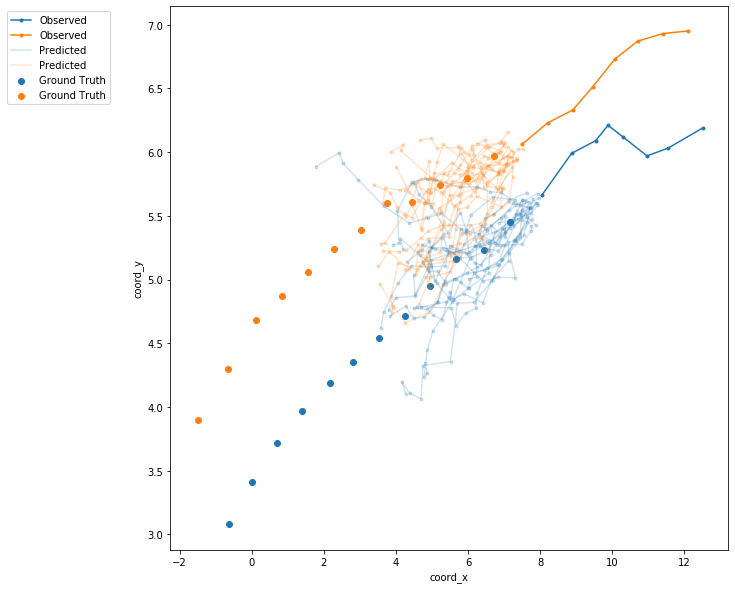

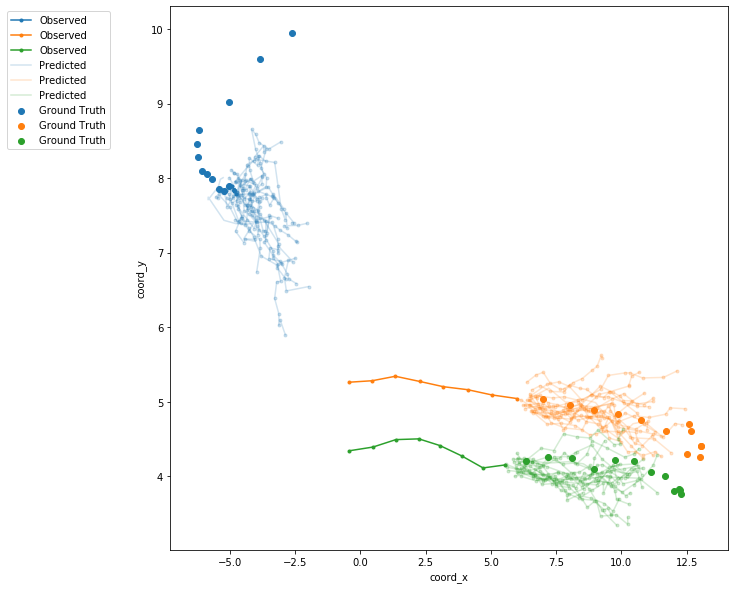

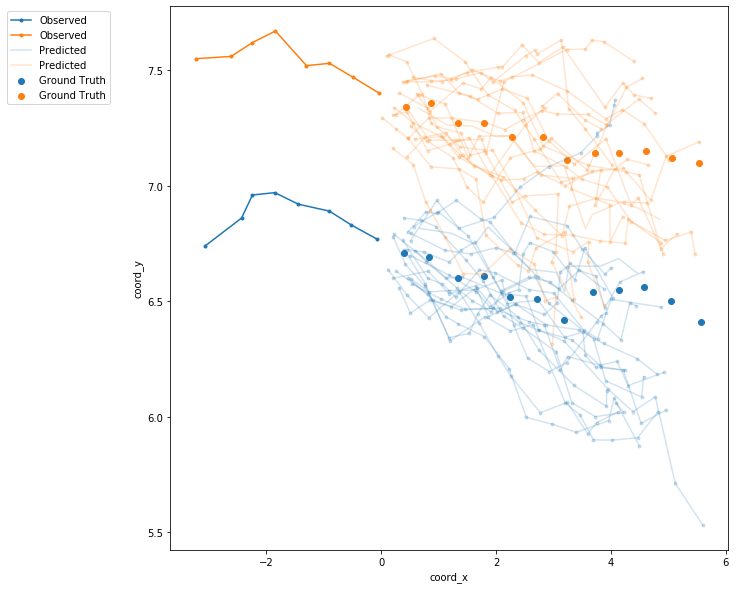

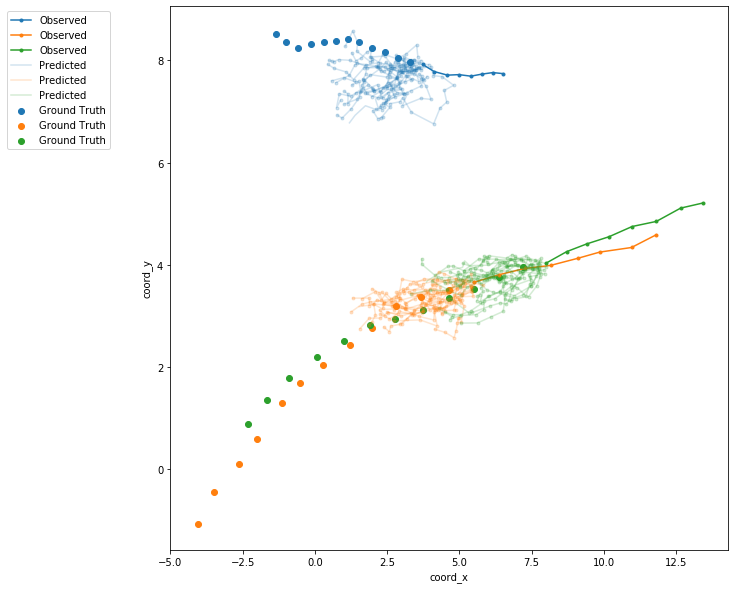

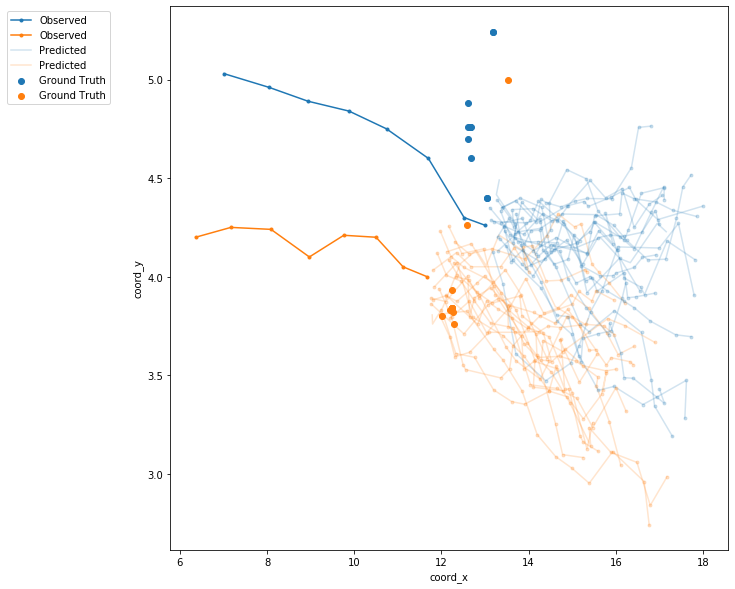

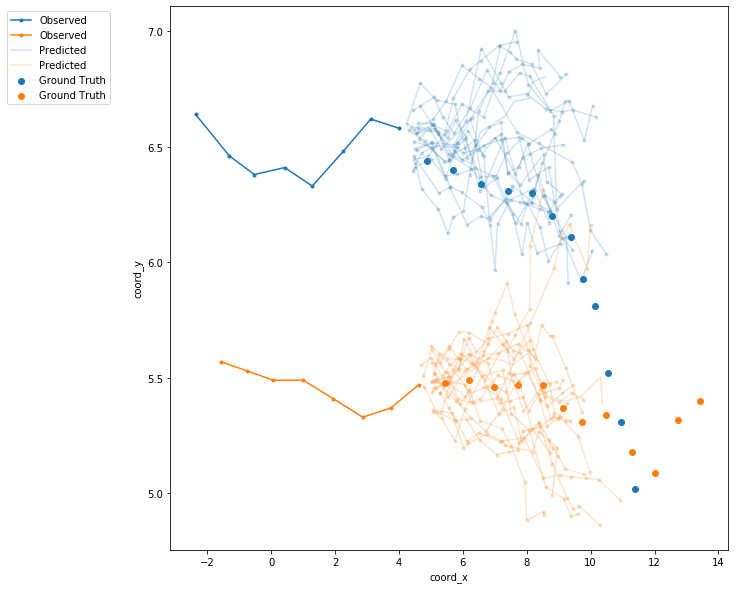

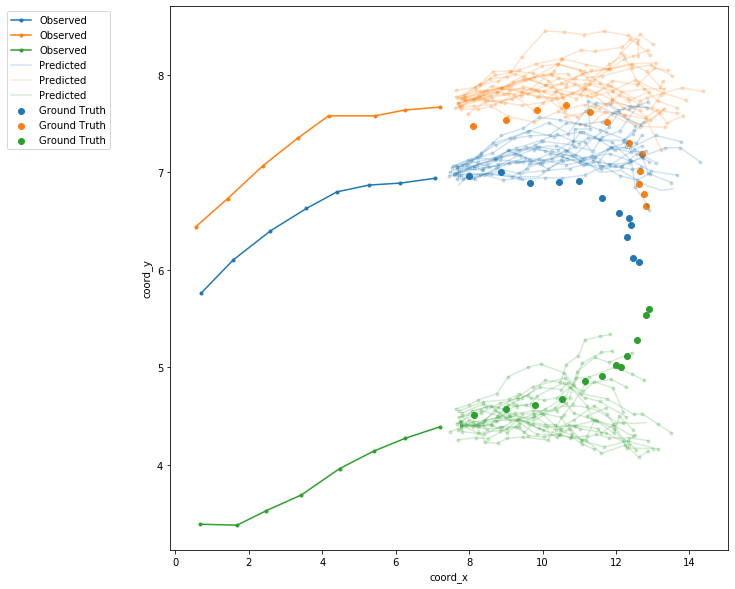

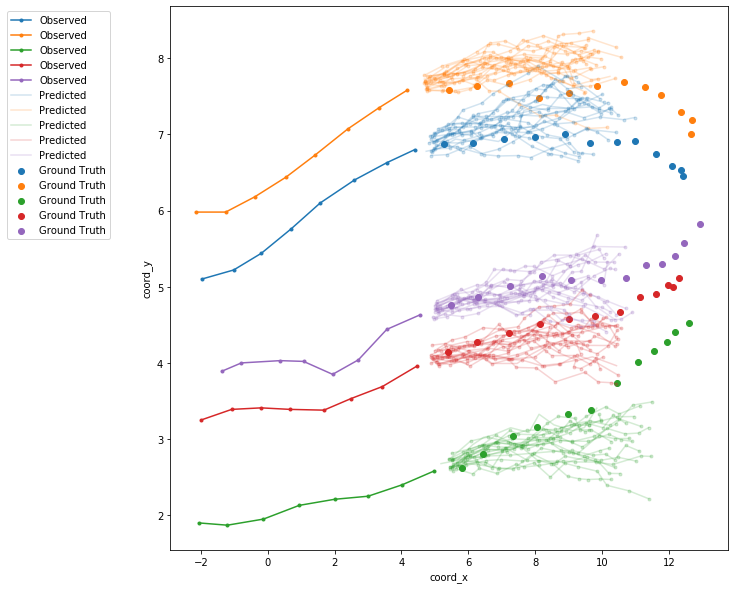

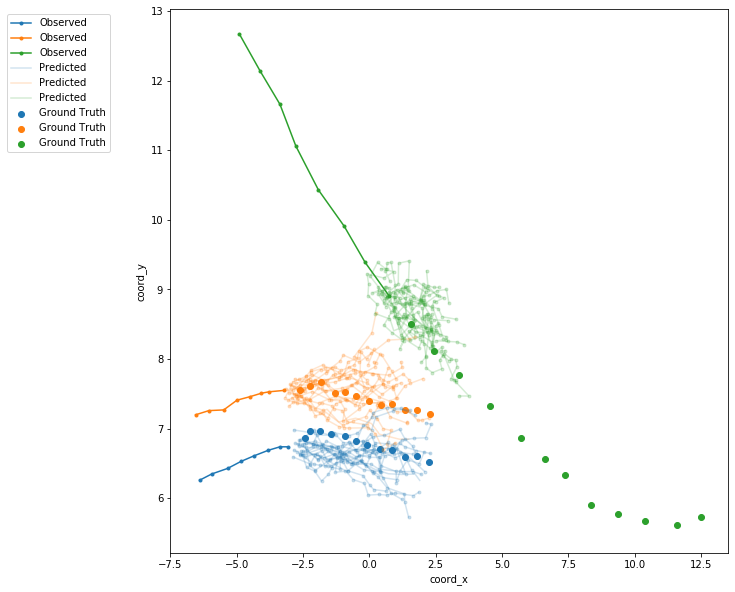

In [200]:
sample_traj_id = [2,31,60,25,39,40,48,45,53]#2, 31,60
for traj_id in sample_traj_id:
    trajs_pred = []
    traj_obs = np.expand_dims(raw_data_dic_[traj_id]['obs'],axis=0).transpose(0,2,3,1) # (1,num_ped,2,seq_len)
    traj_trgt = np.expand_dims(raw_data_dic_[traj_id]['trgt'],axis=0).transpose(0,2,3,1) # (1,num_ped,2,pred_seq_len)
    for i in range(20):
        trajs_pred.append(np.expand_dims(raw_data_dic_[traj_id]['pred'][i],axis=0).transpose(0,2,3,1)) # (1,num_ped,2,pred_seq_len)
    plot_trajs(traj_obs,traj_trgt,trajs_pred)

0


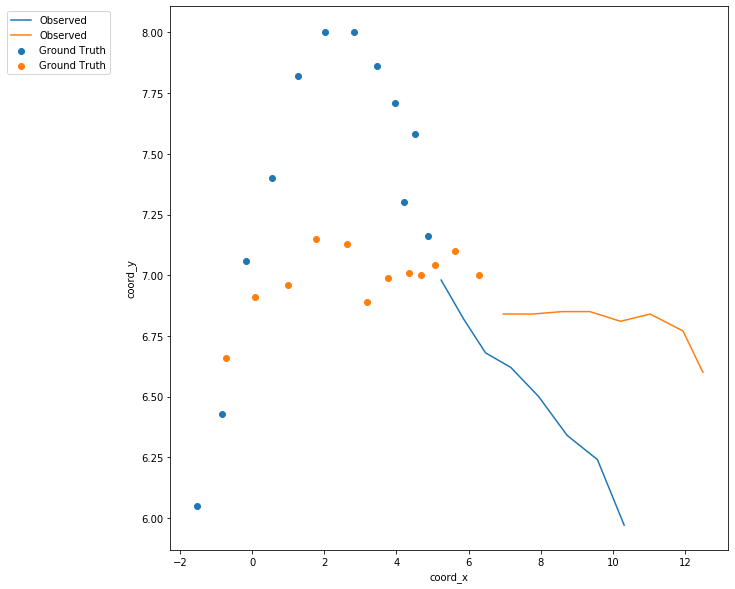

1


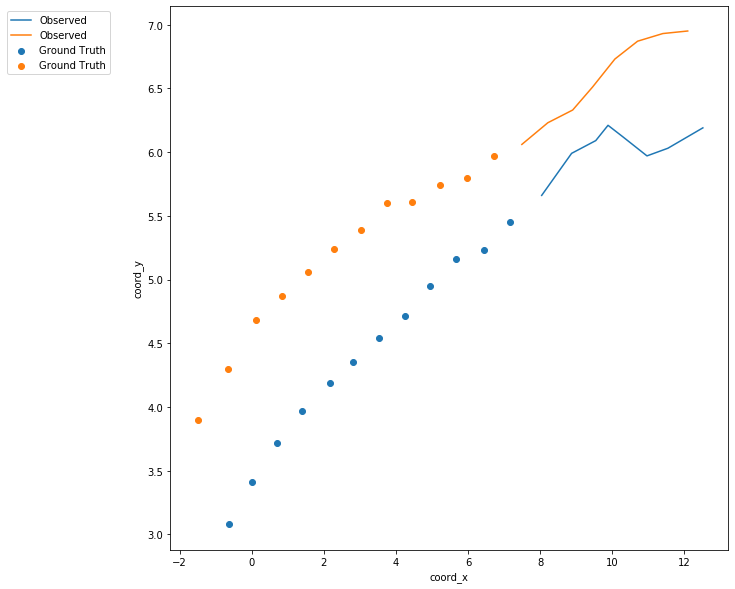

2


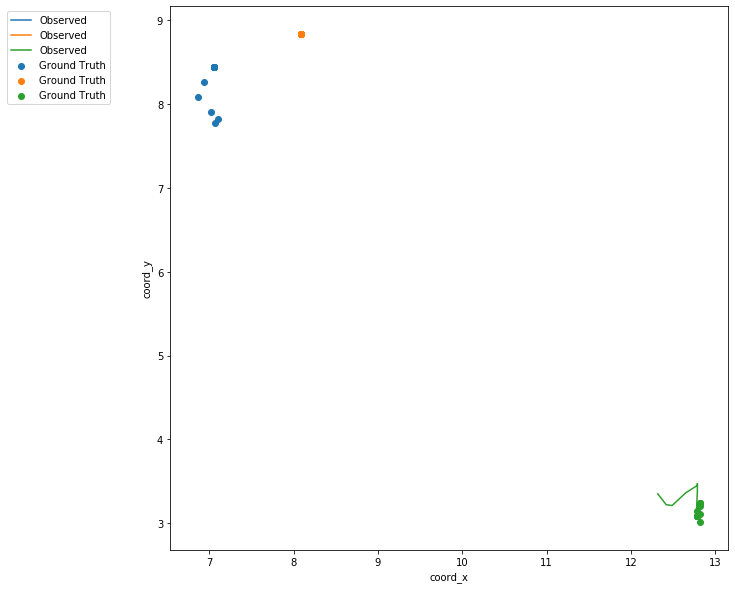

3


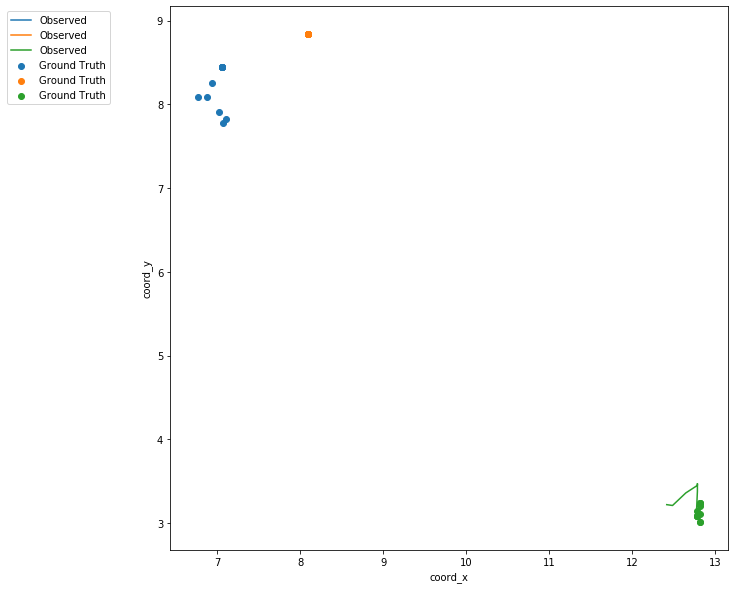

4


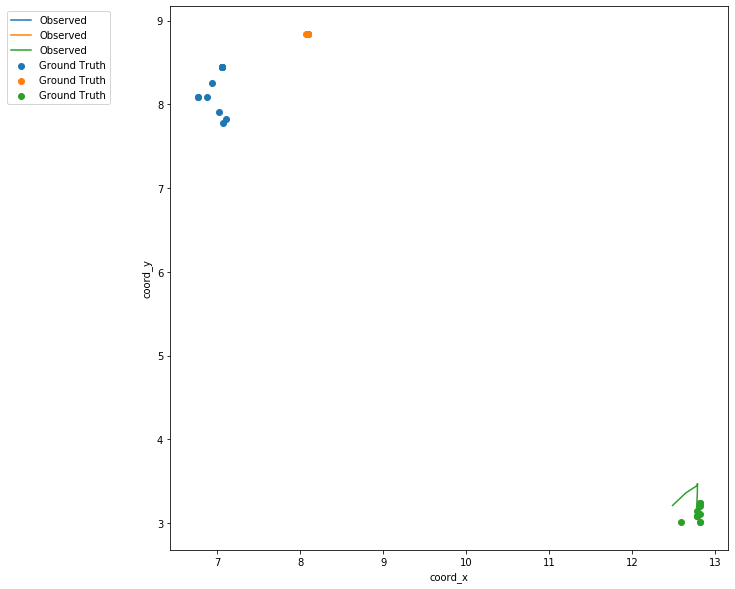

5


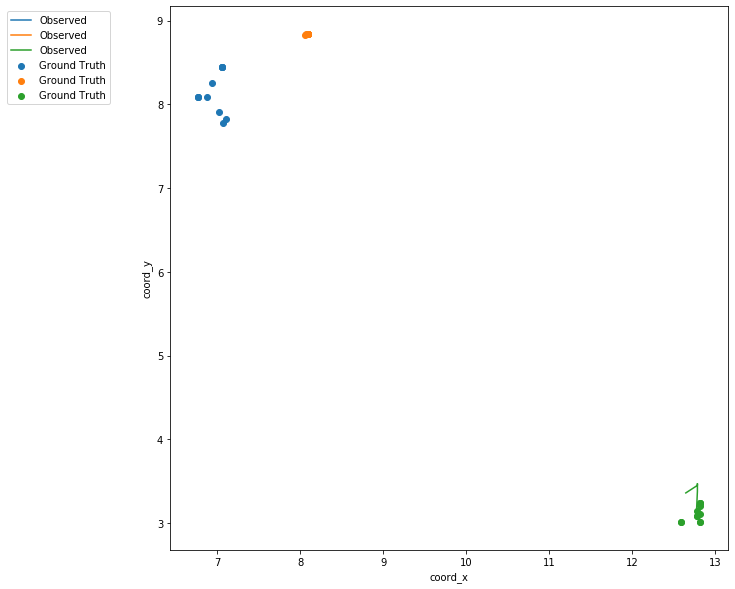

6


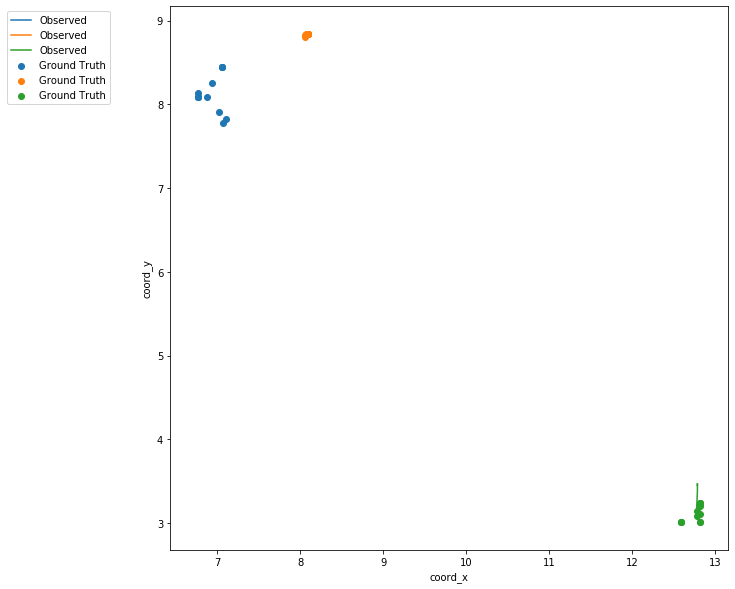

7


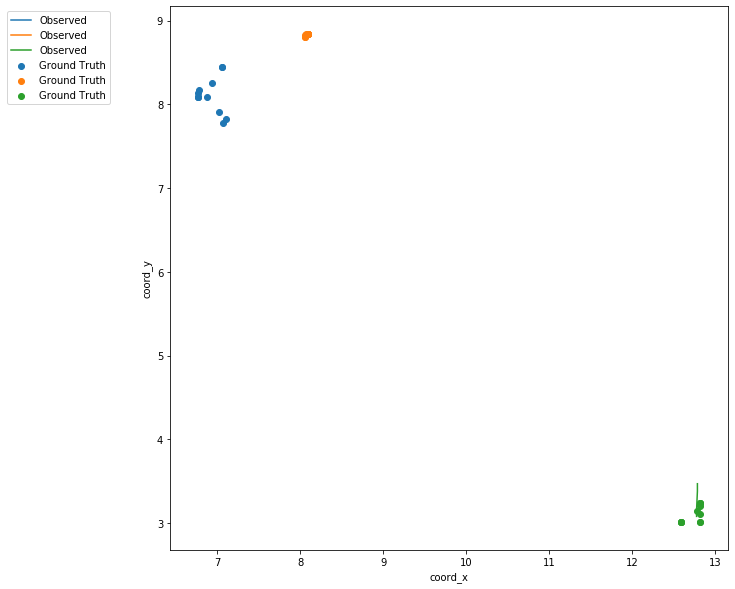

8


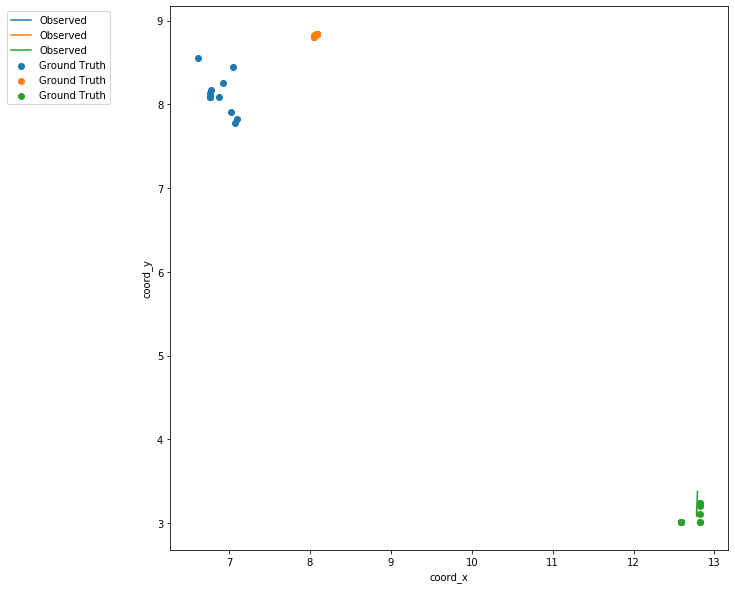

9


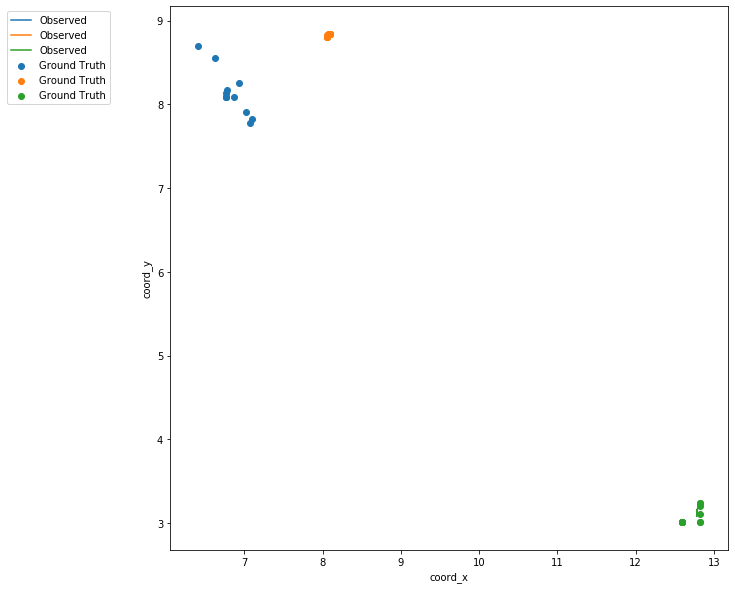

10


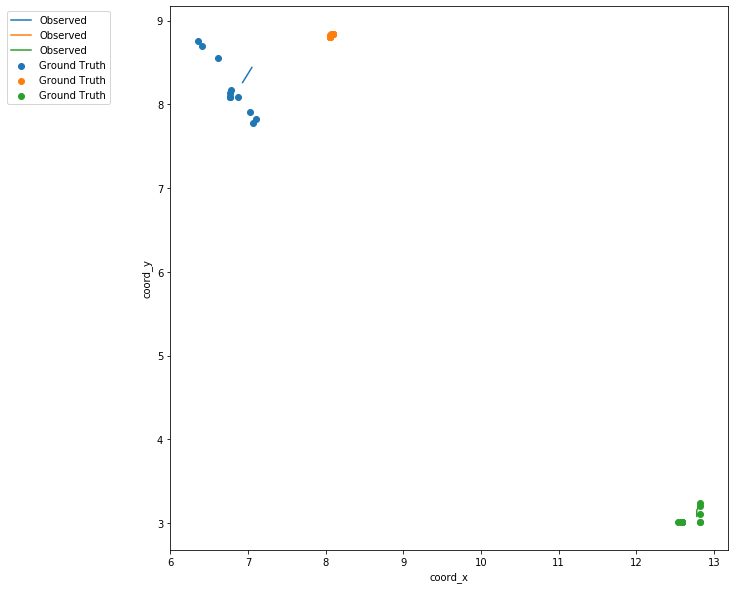

11


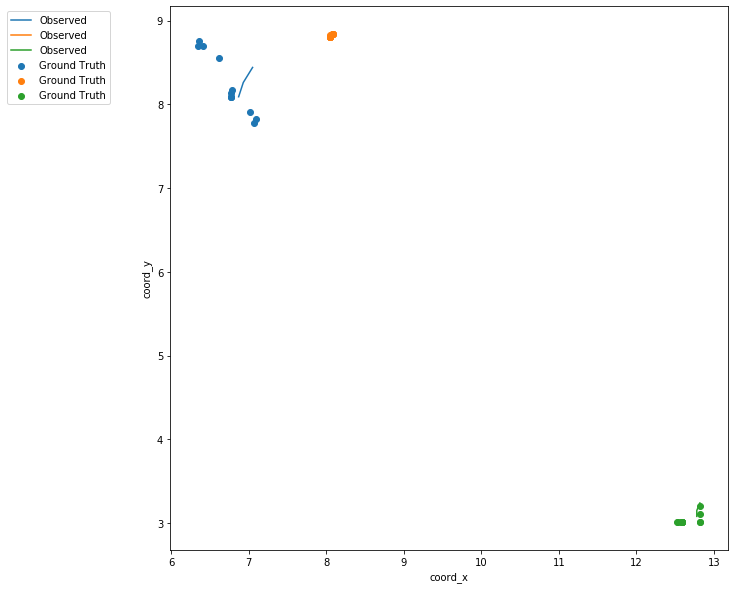

12


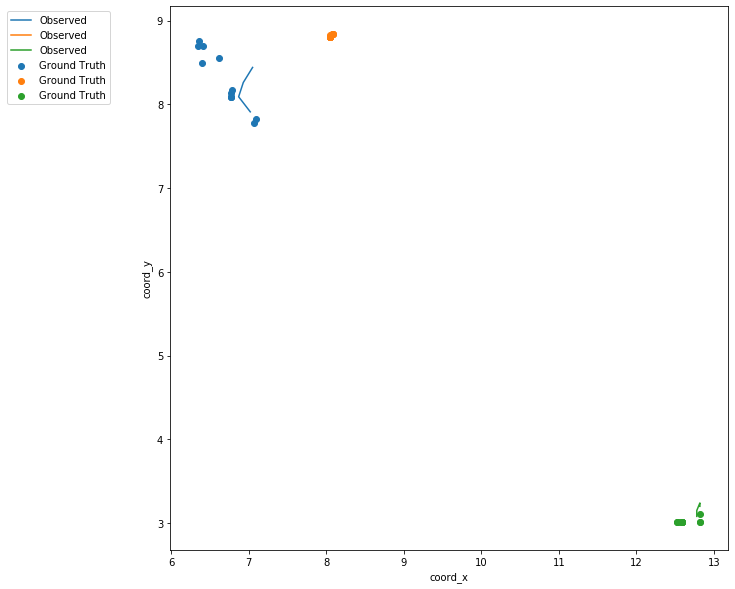

13


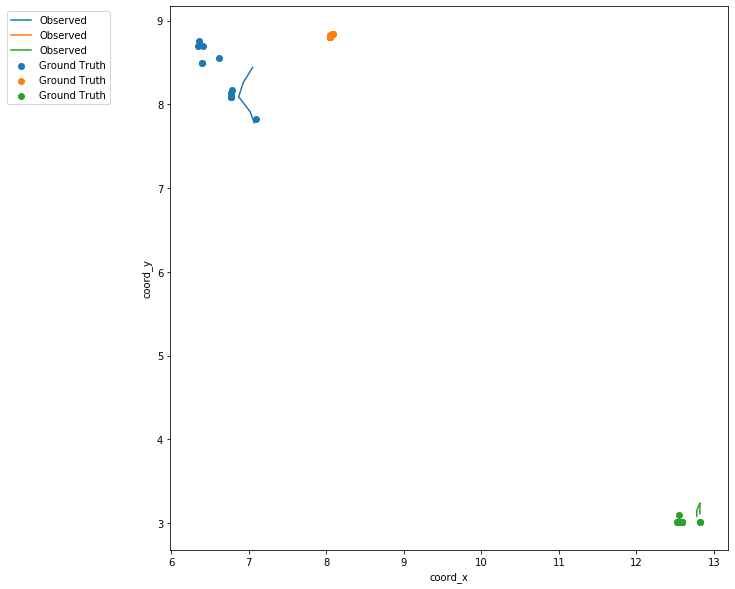

14


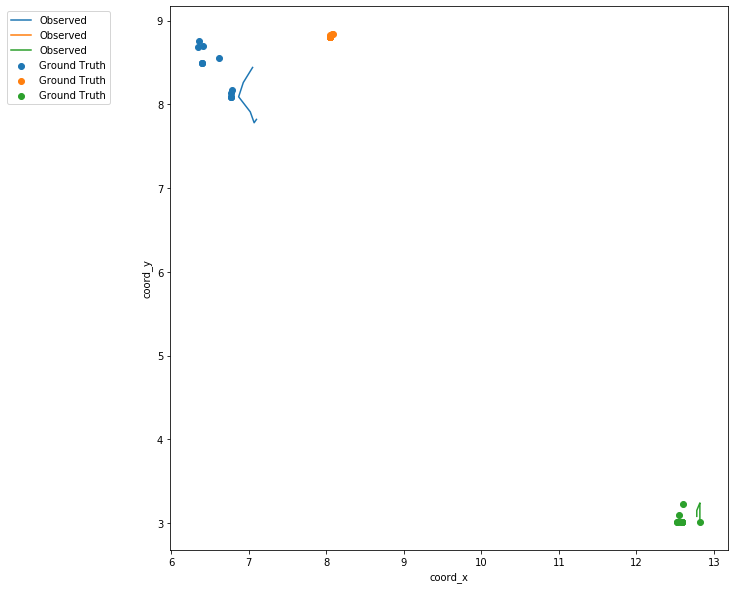

15


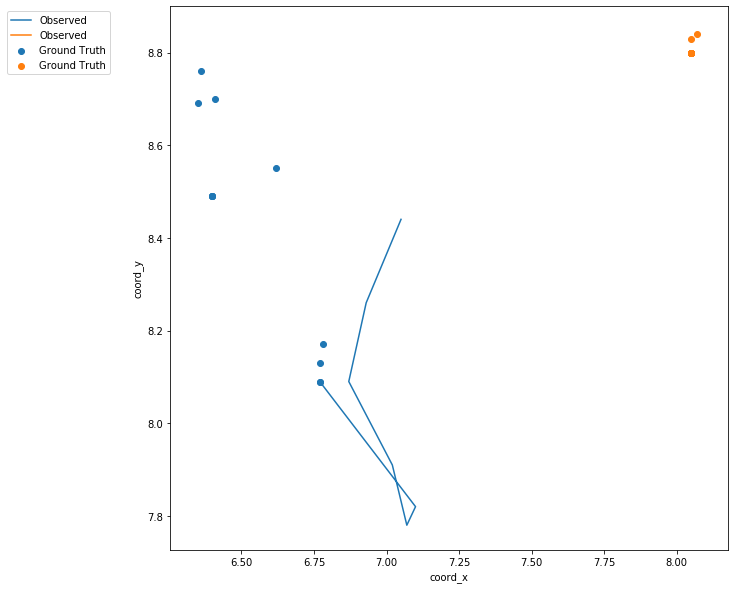

16


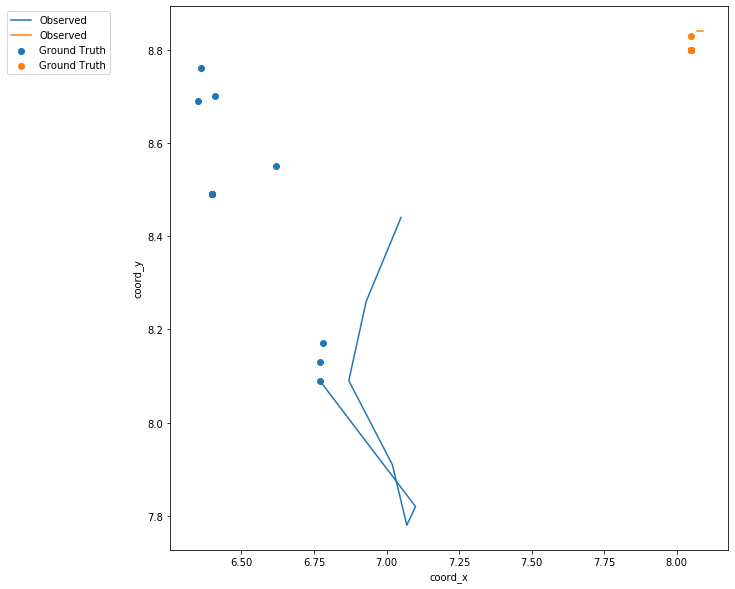

17


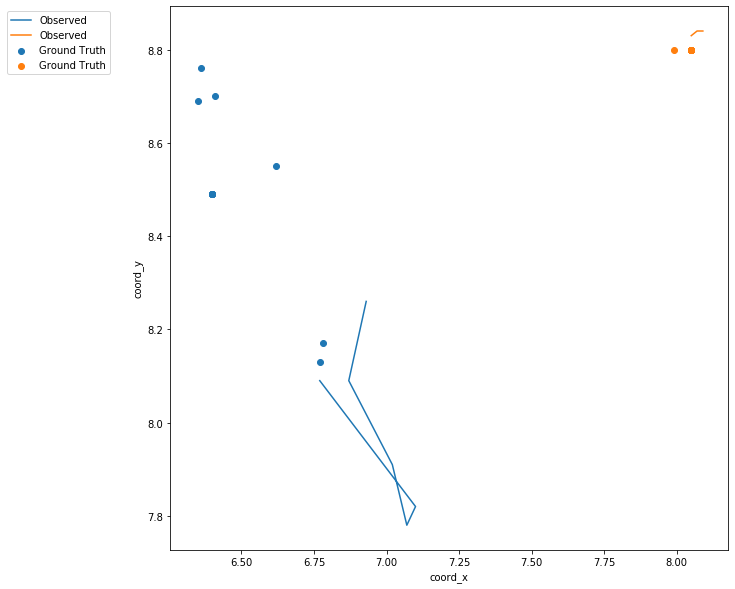

18


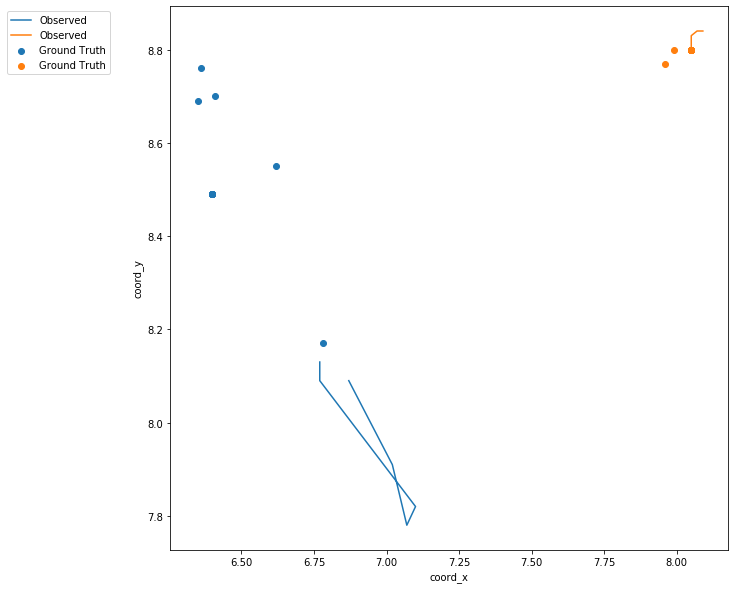

19


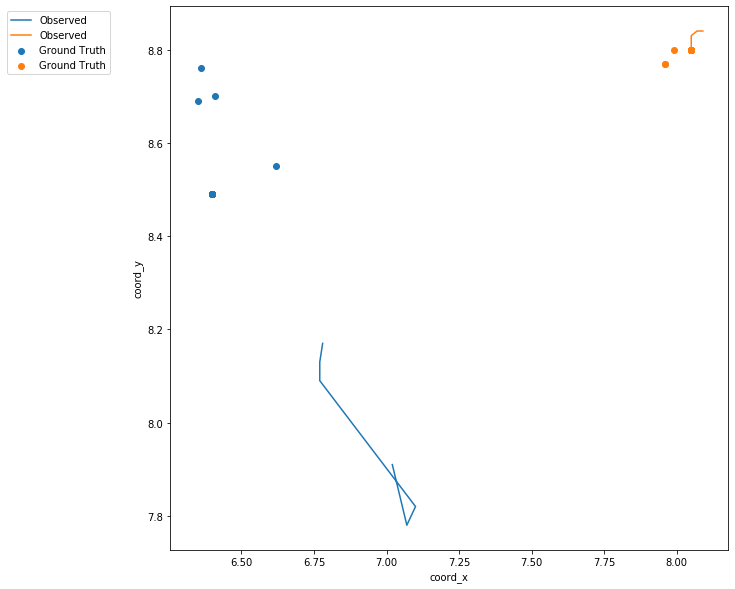

20


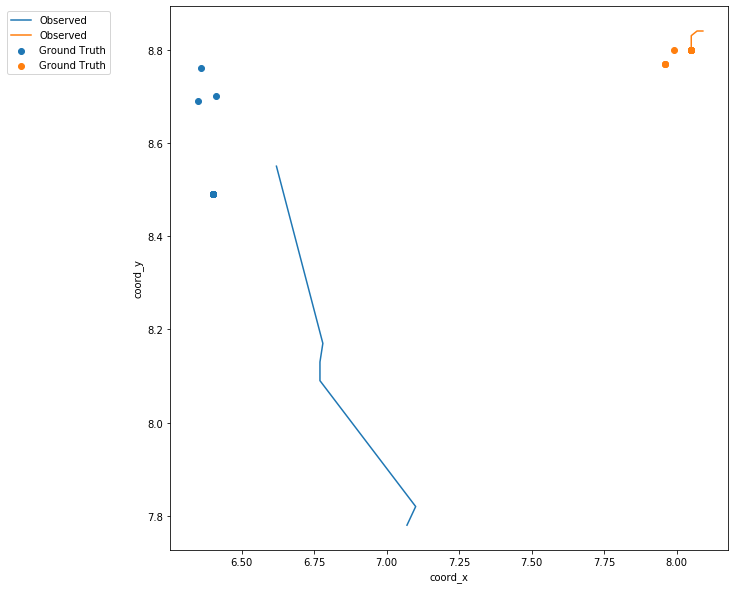

21


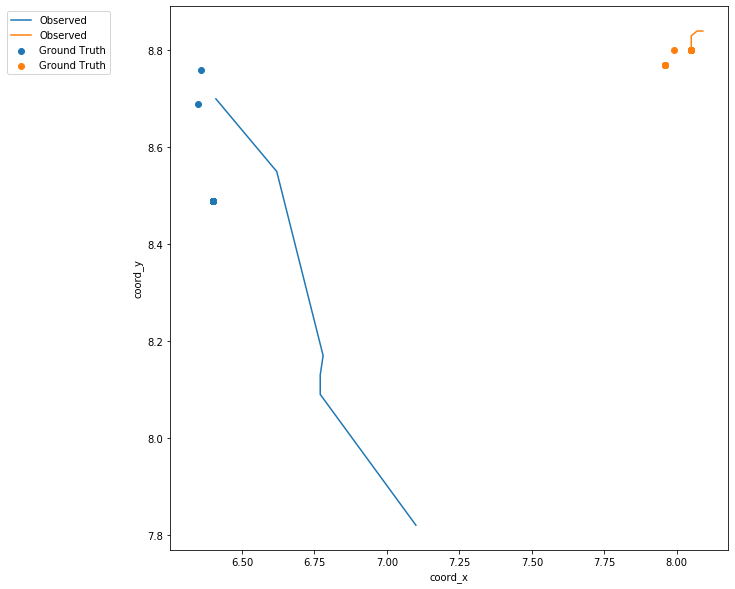

22


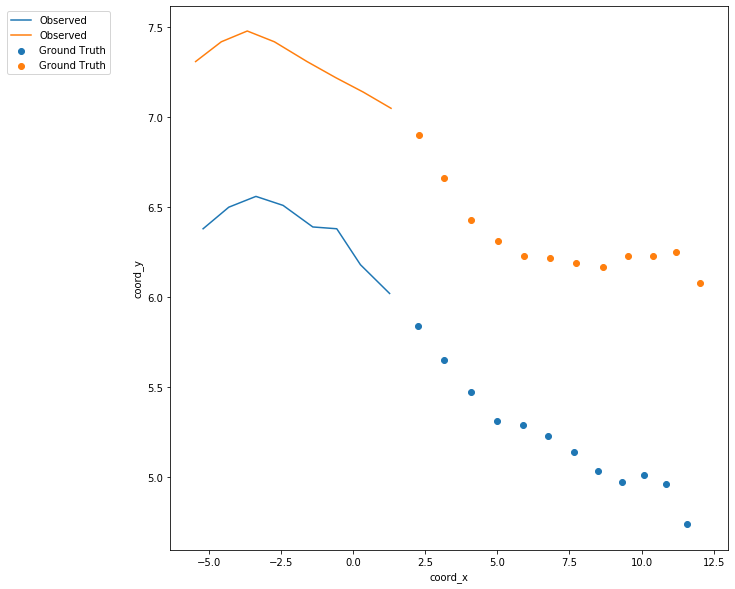

23


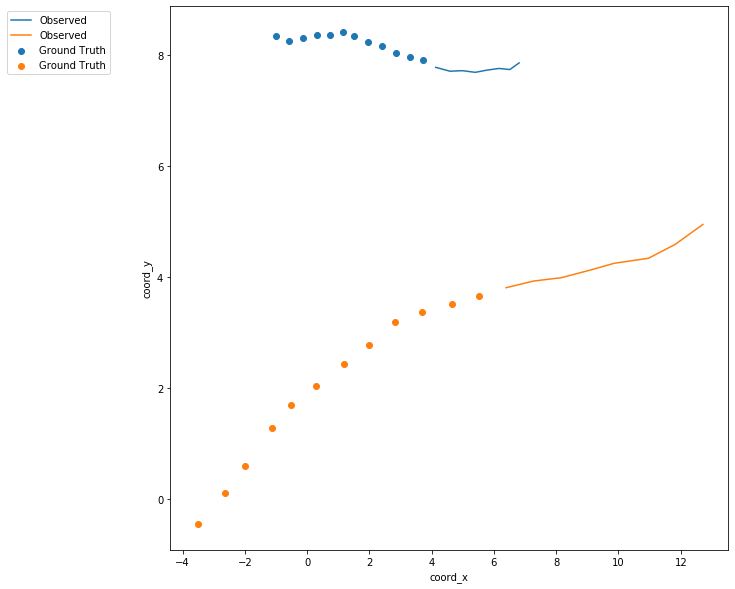

24


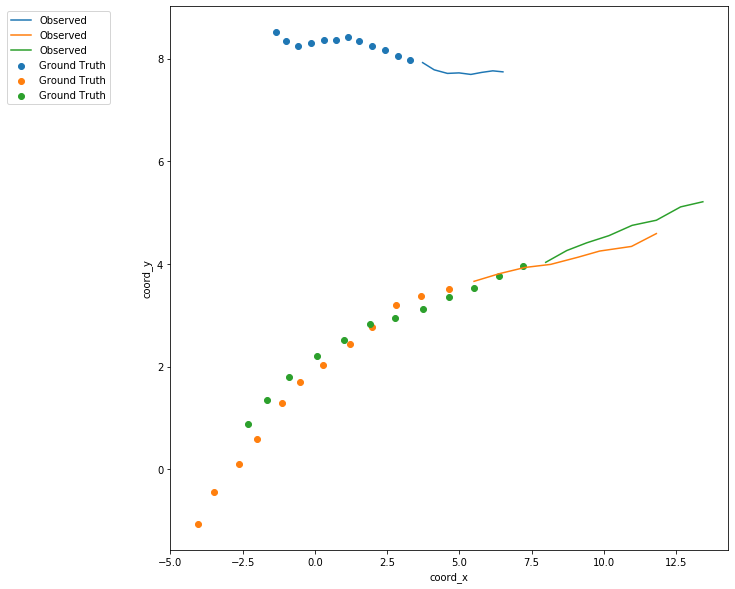

25


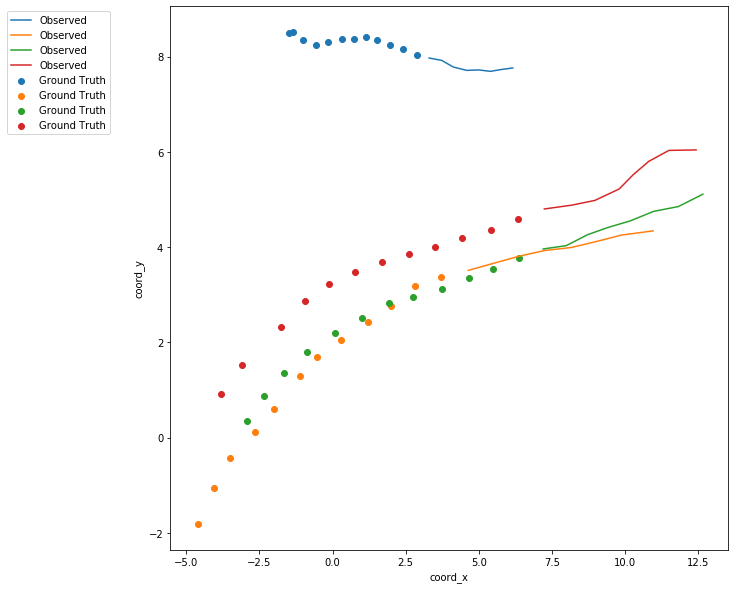

26


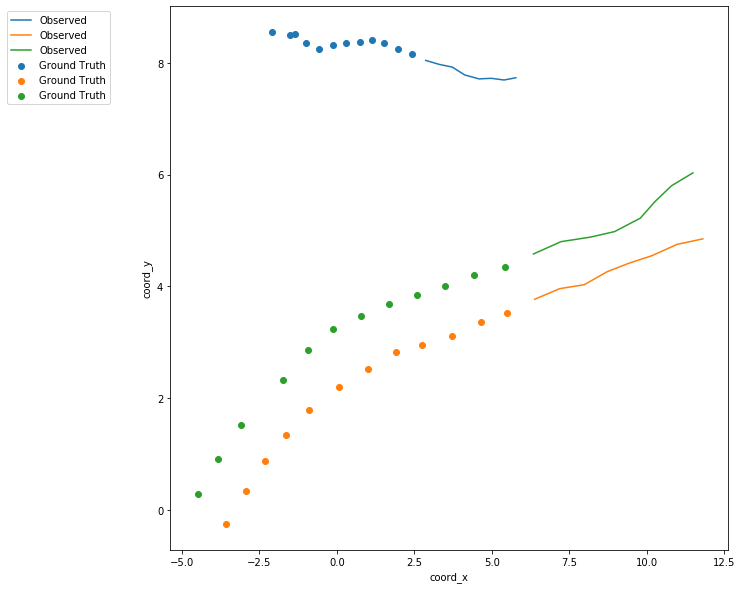

27


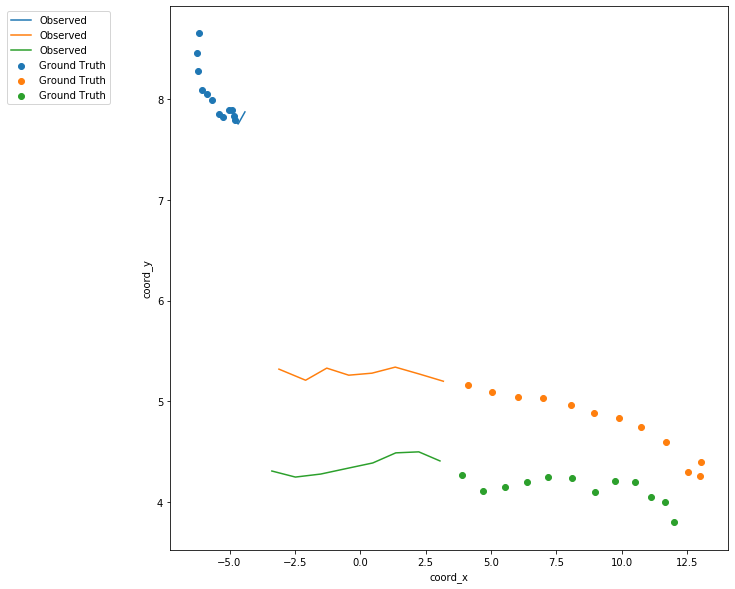

28


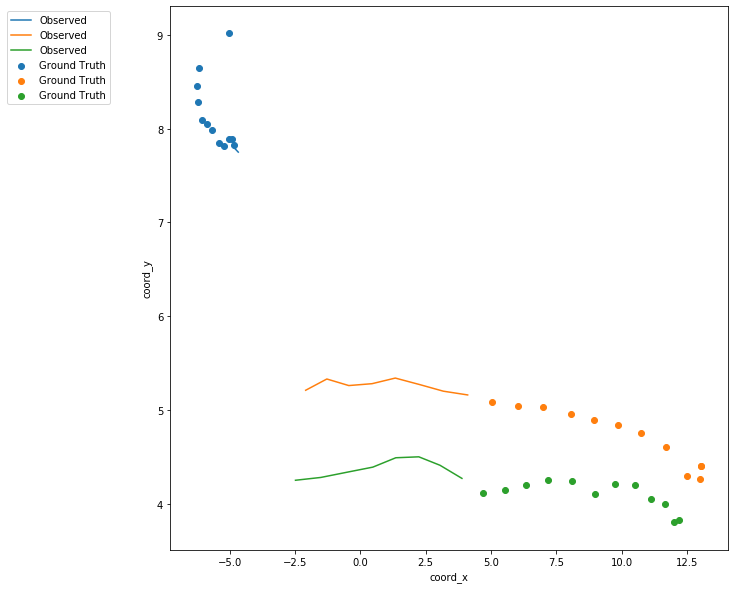

29


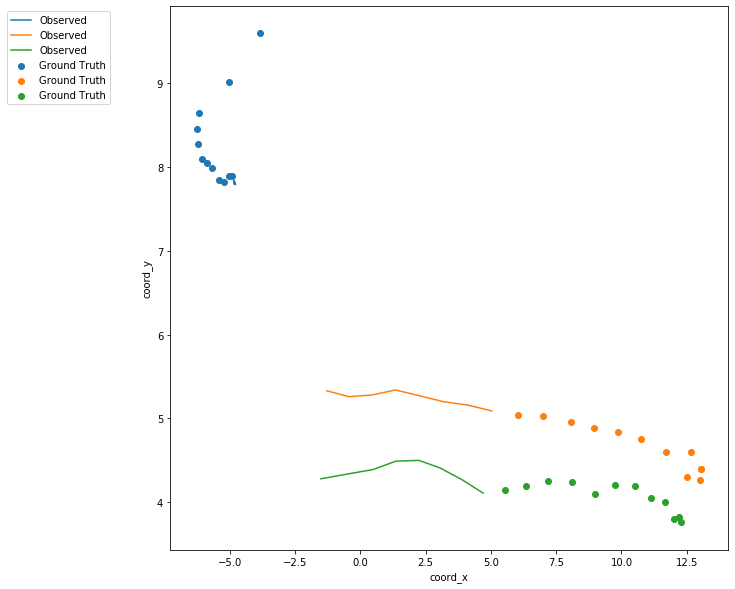

30


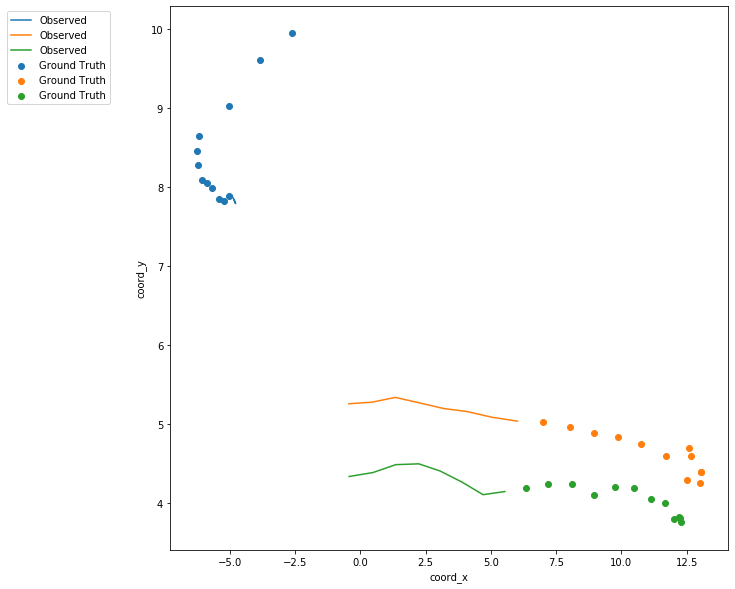

31


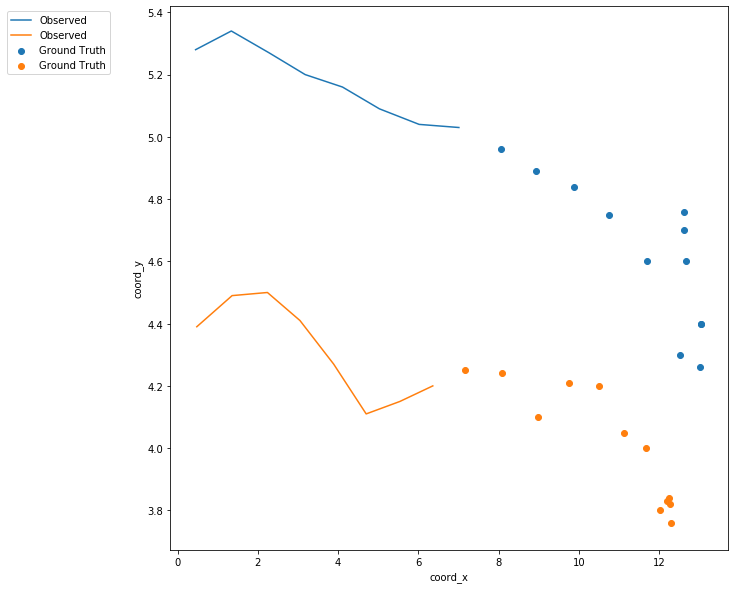

32


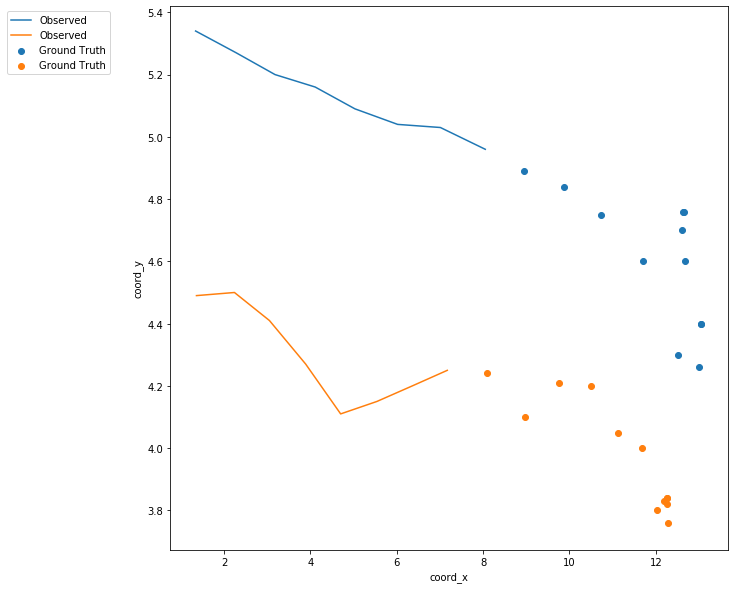

33


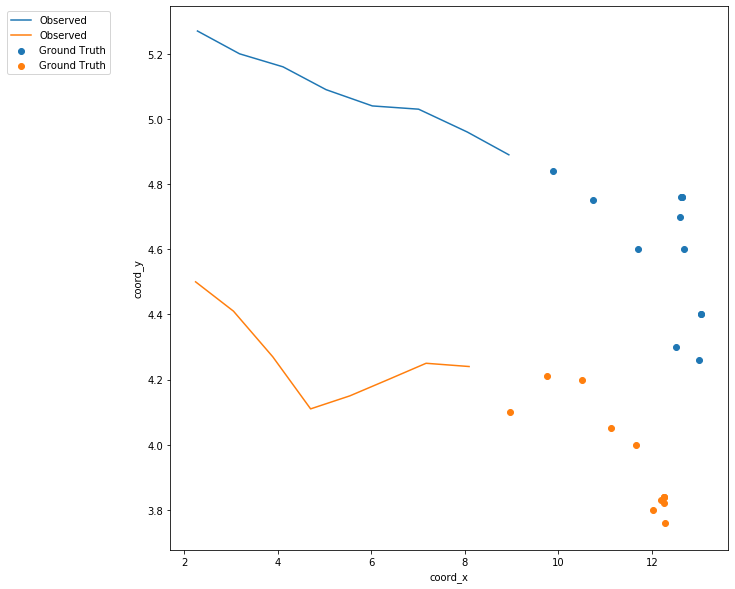

34


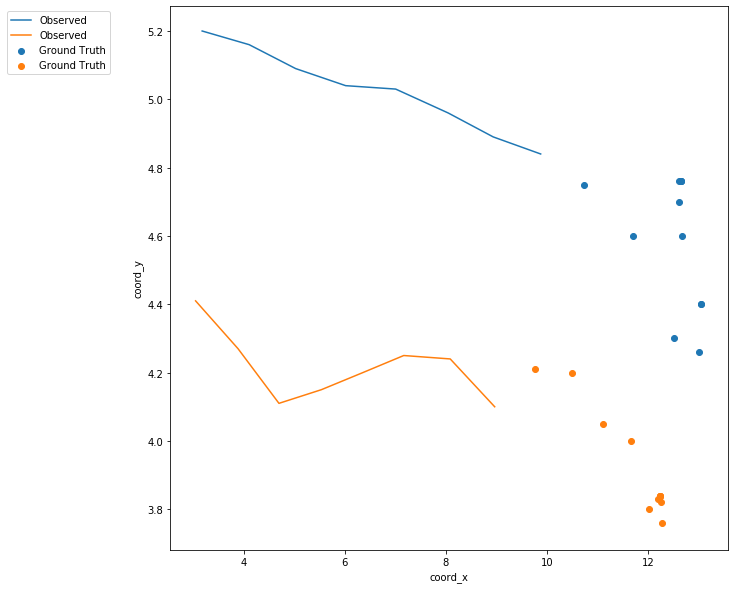

35


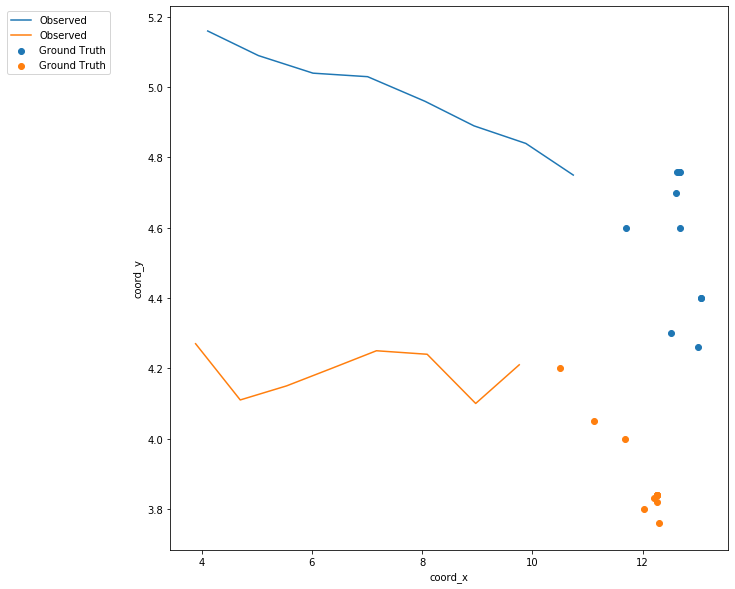

36


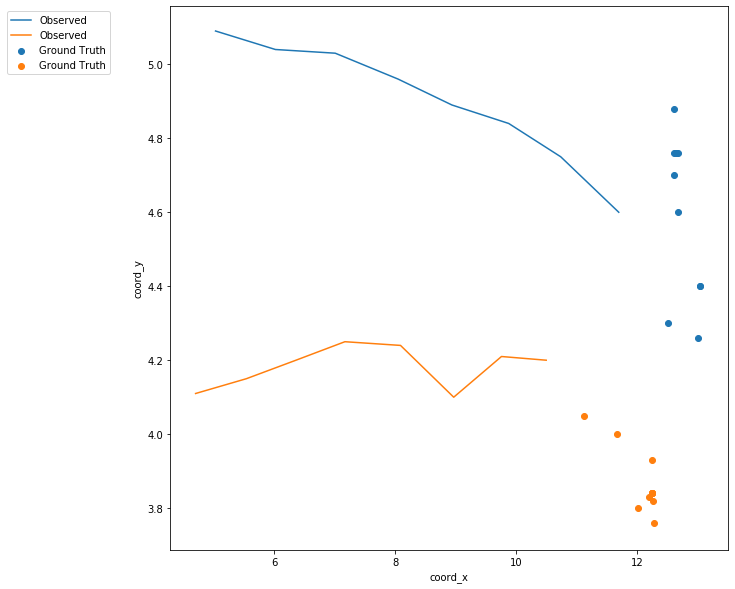

37


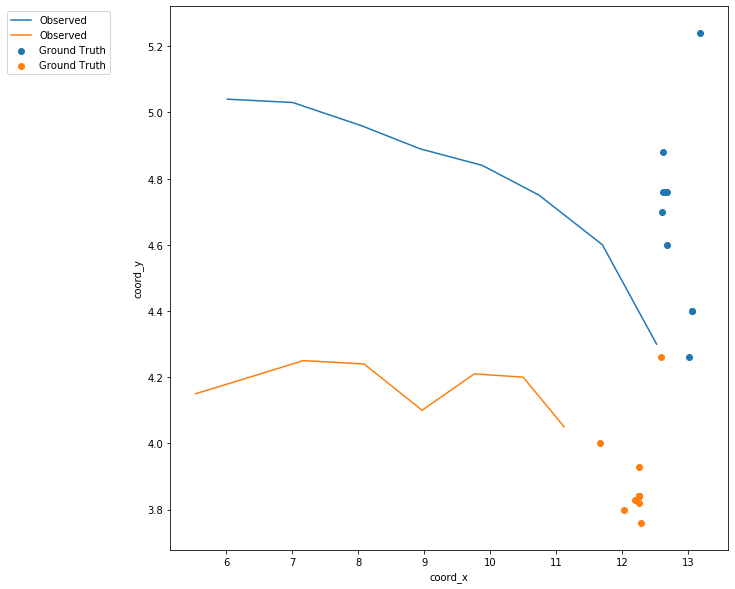

38


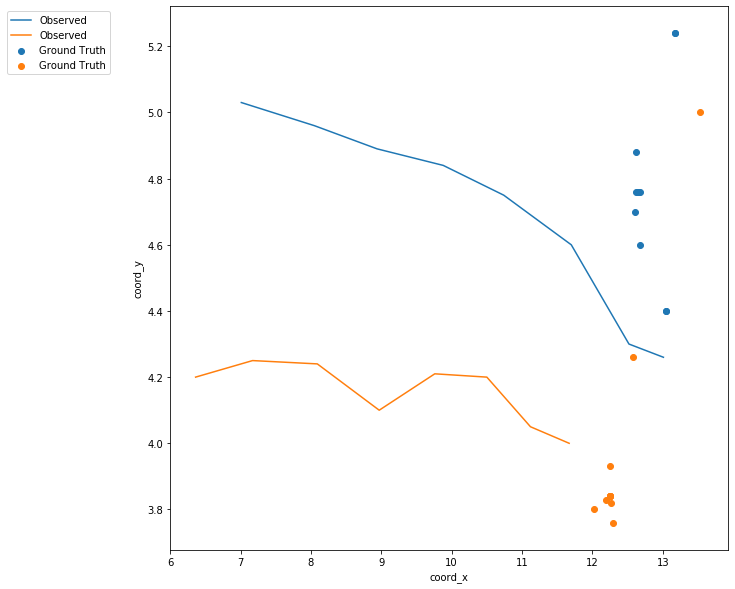

39


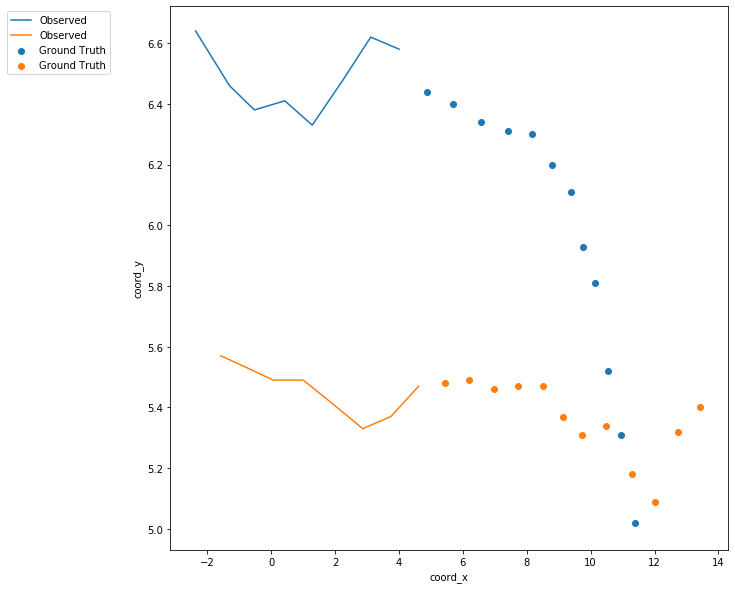

40


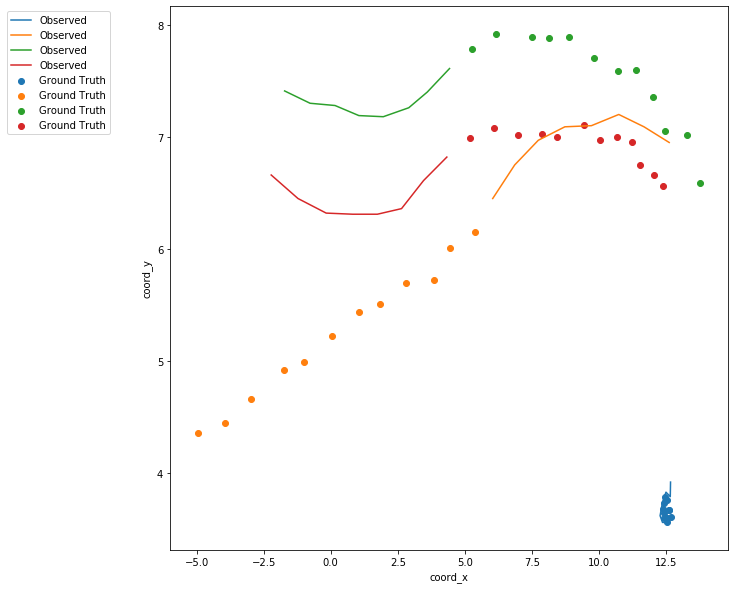

41


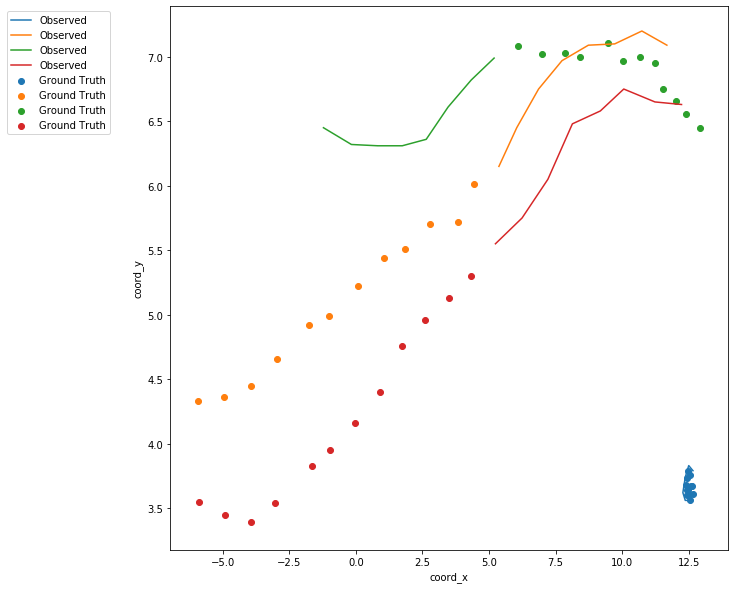

42


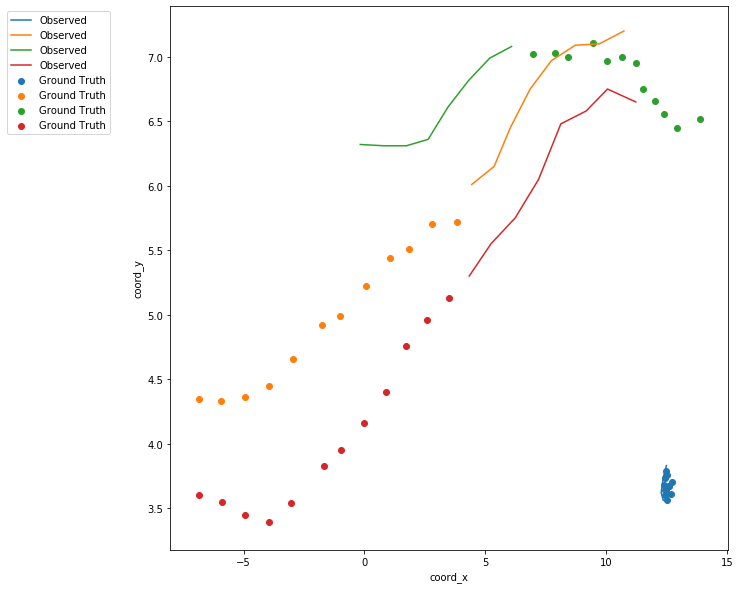

43


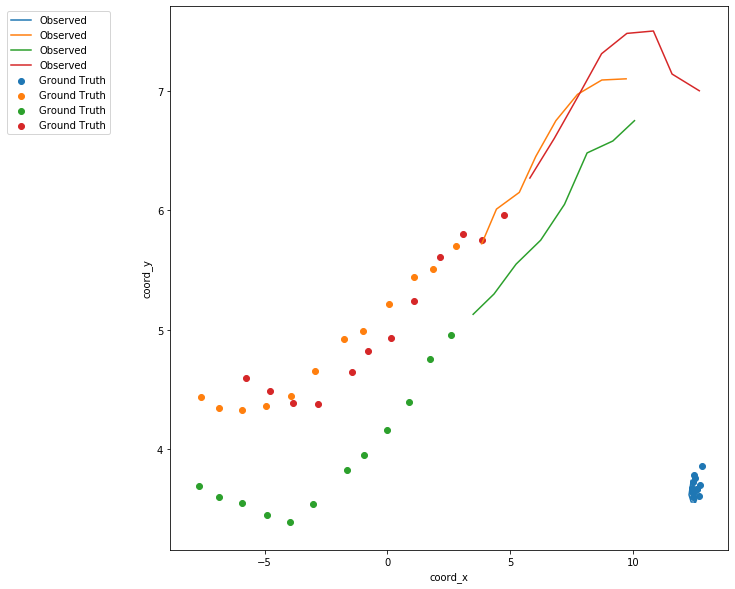

44


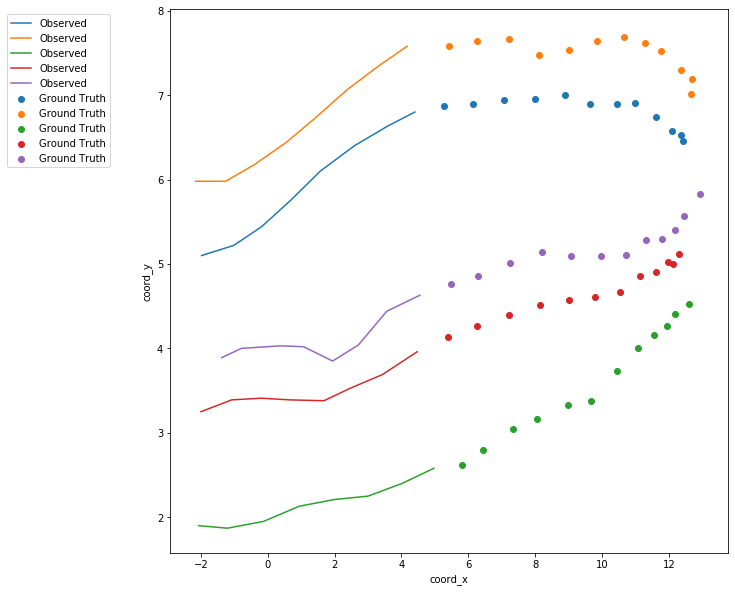

45


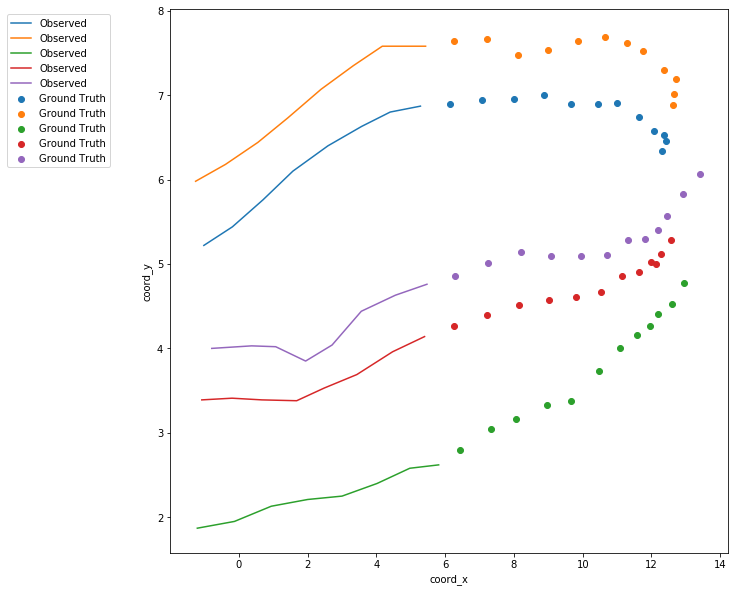

46


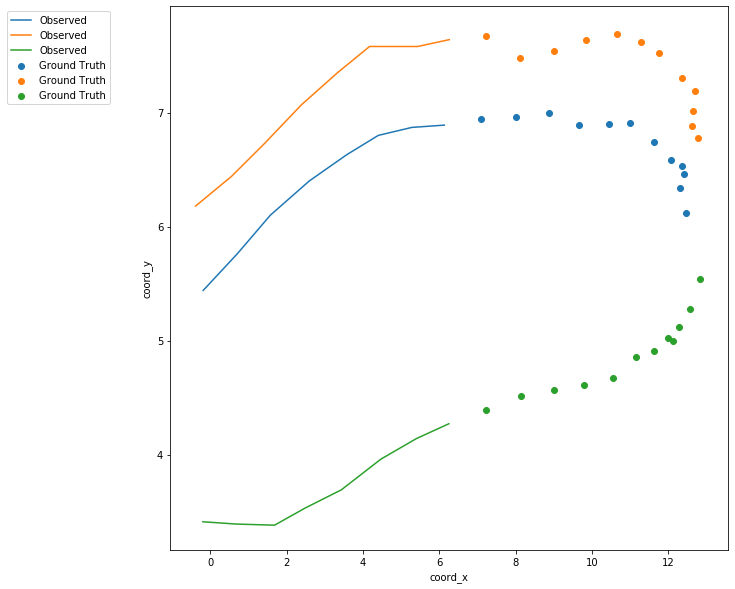

47


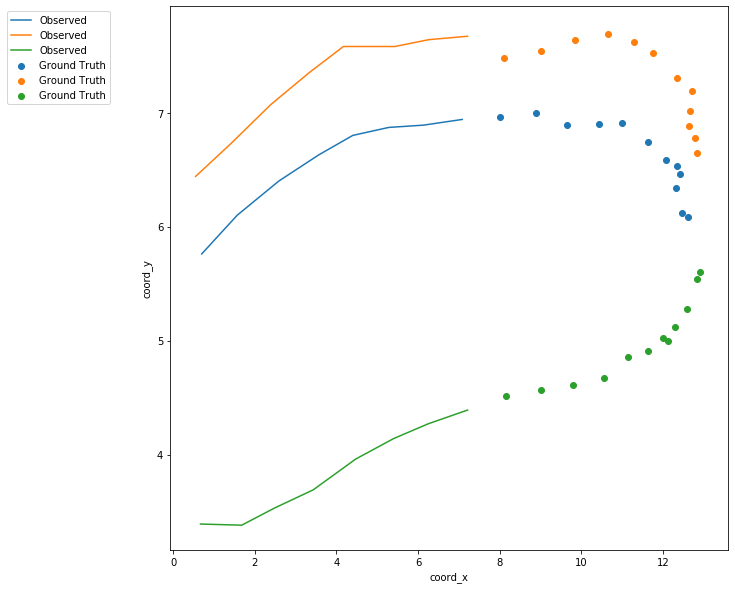

48


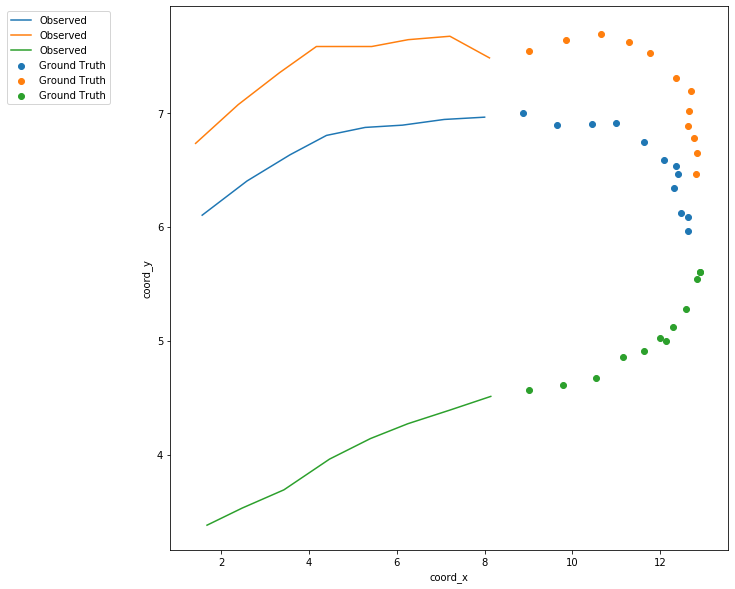

49


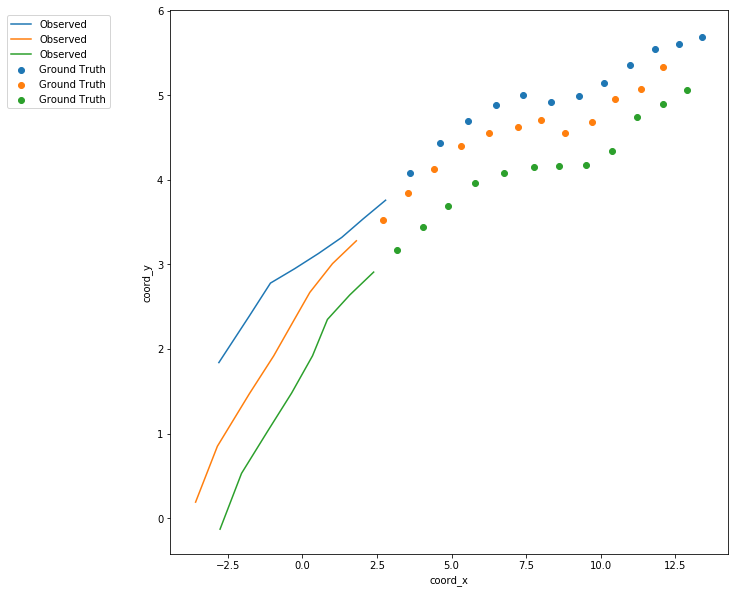

50


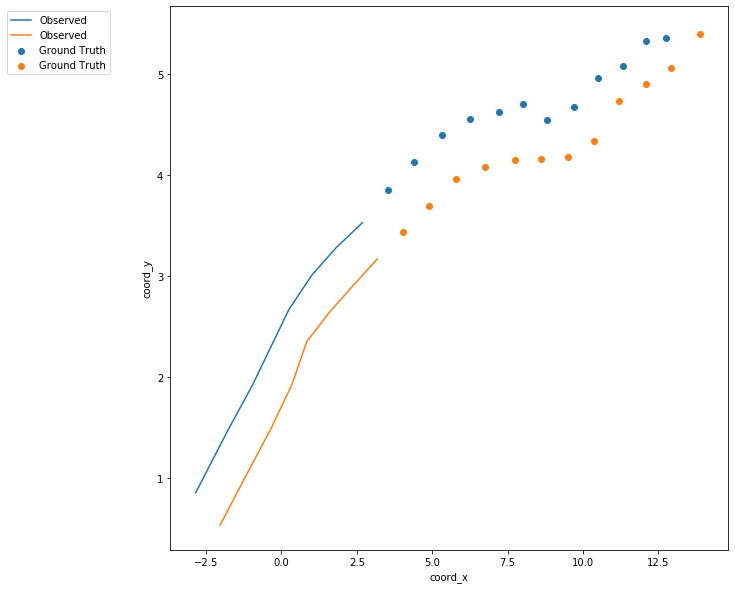

51


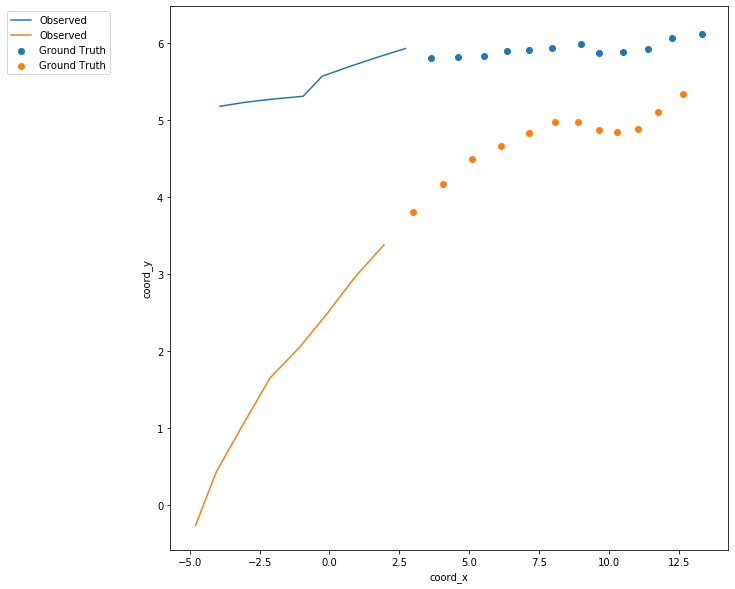

52


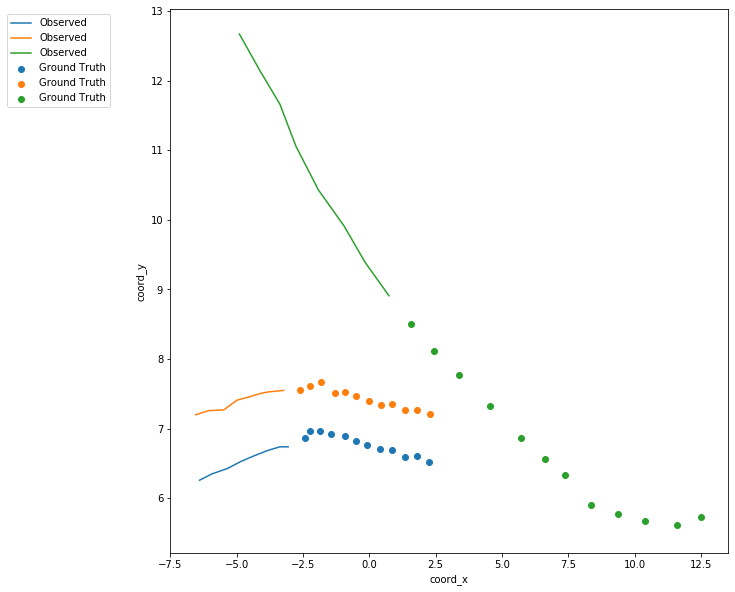

53


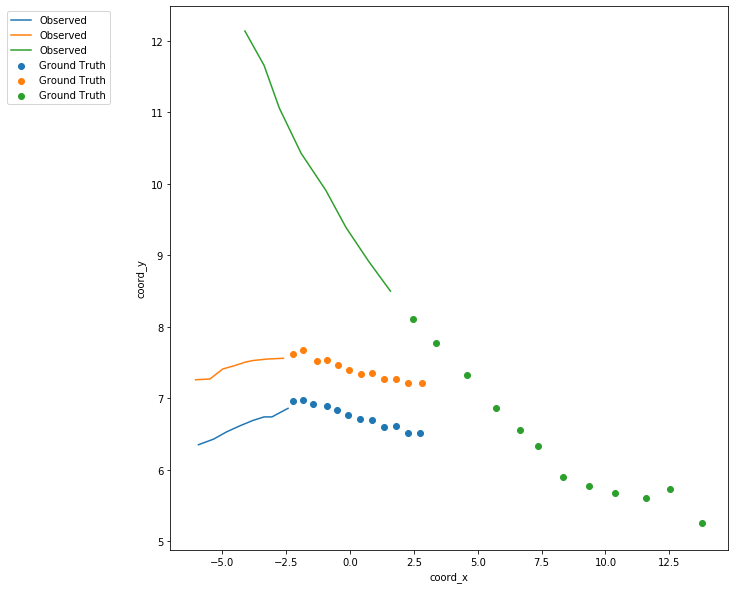

54


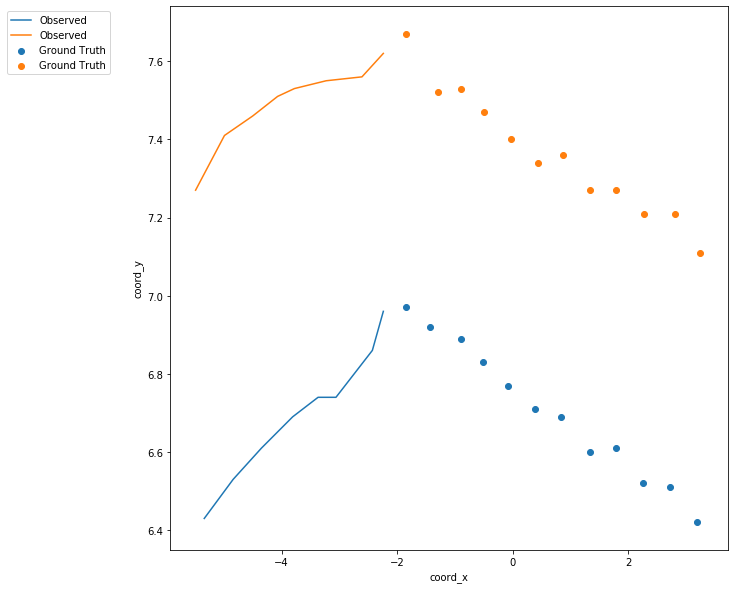

55


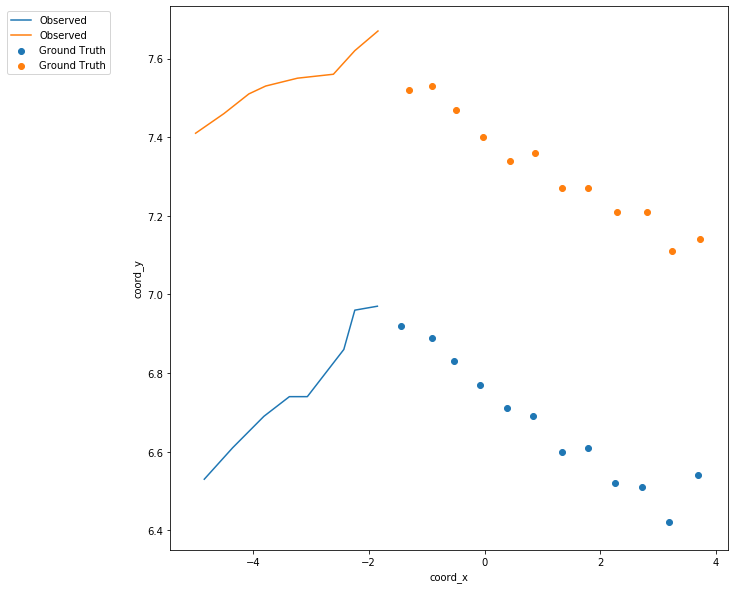

56


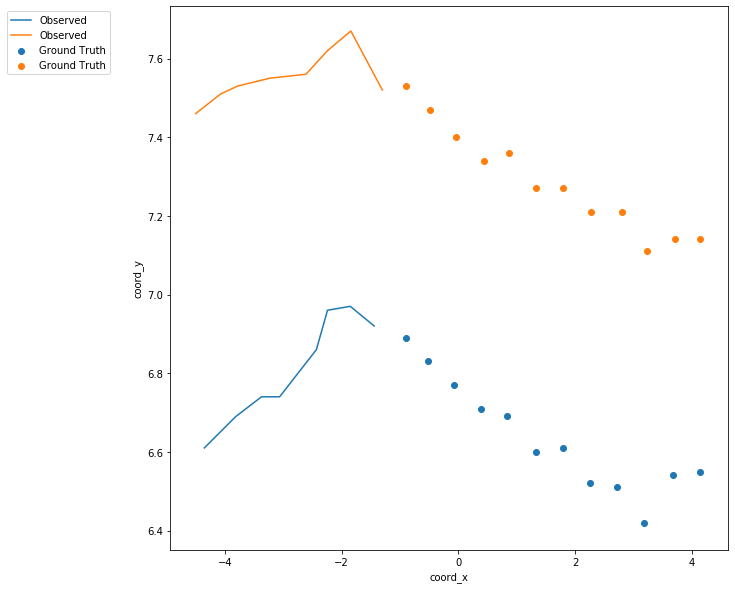

57


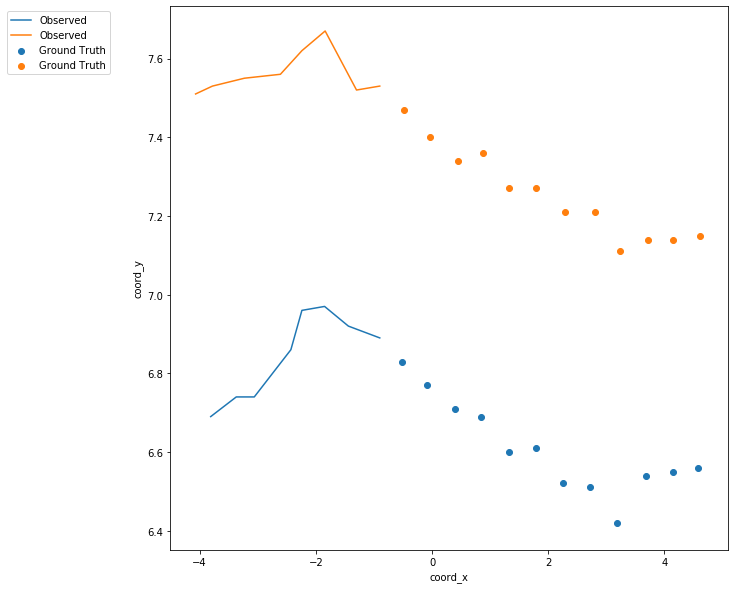

58


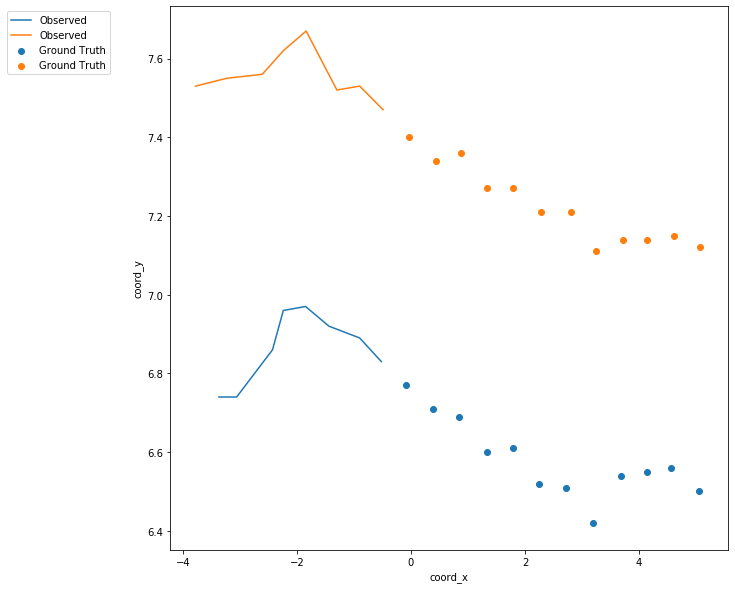

59


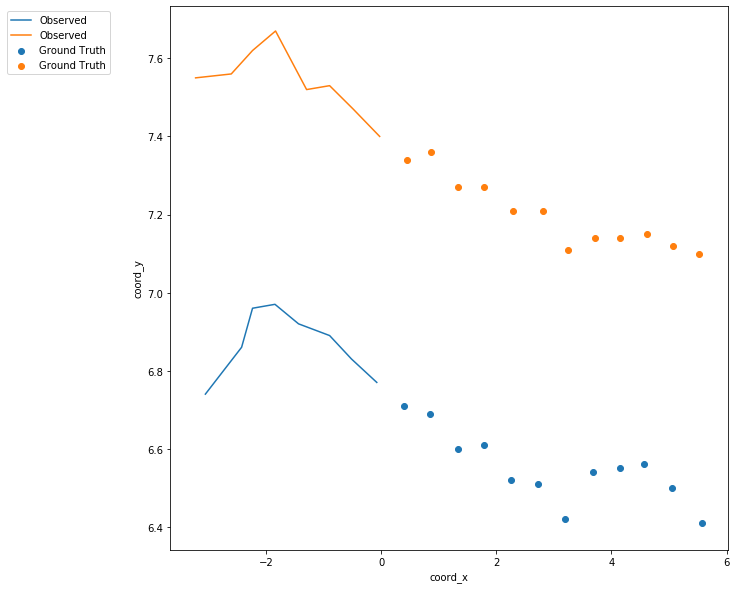

60


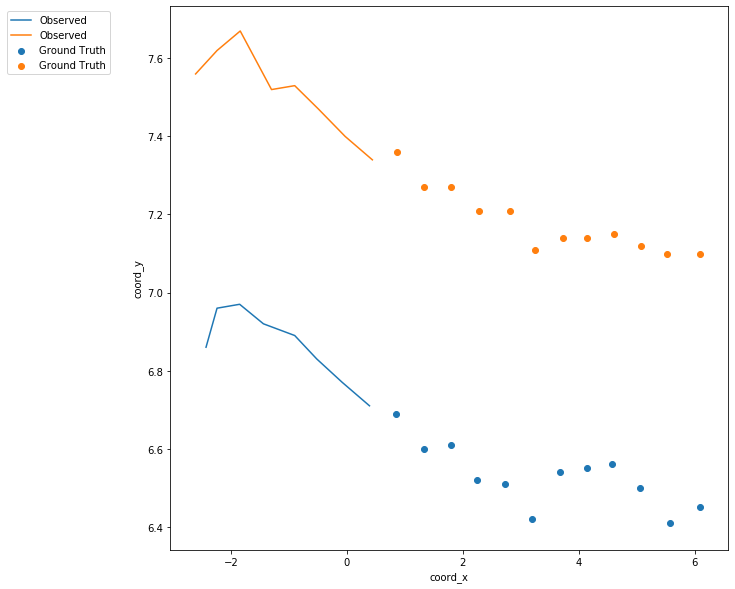

61


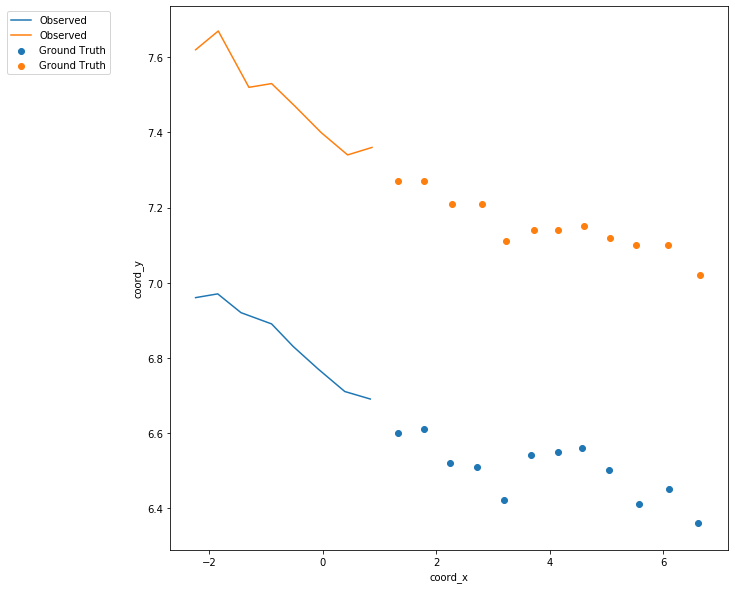

62


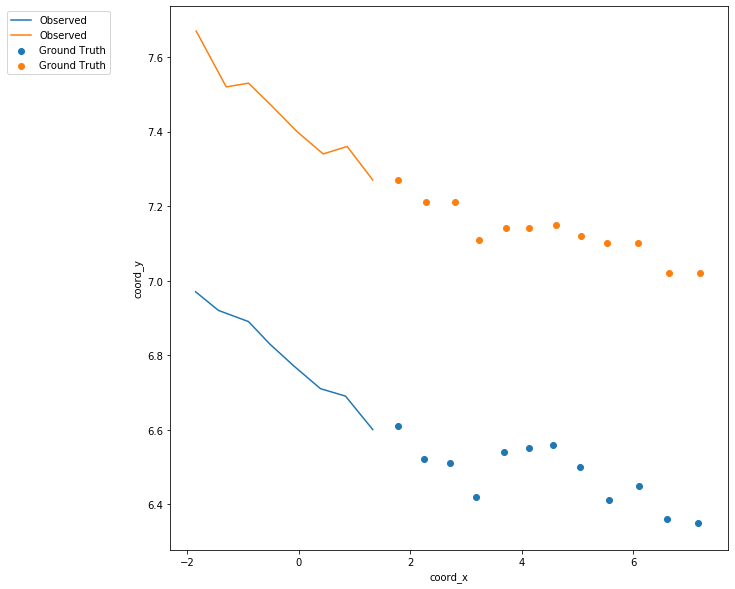

63


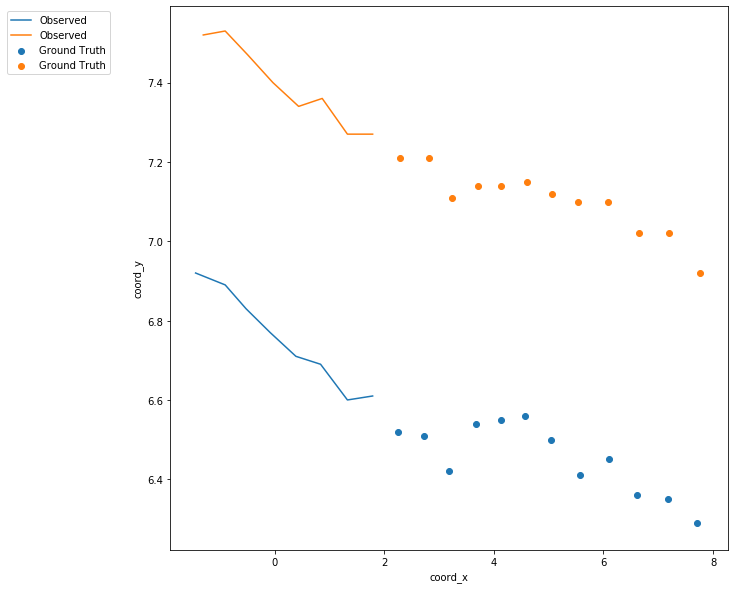

64


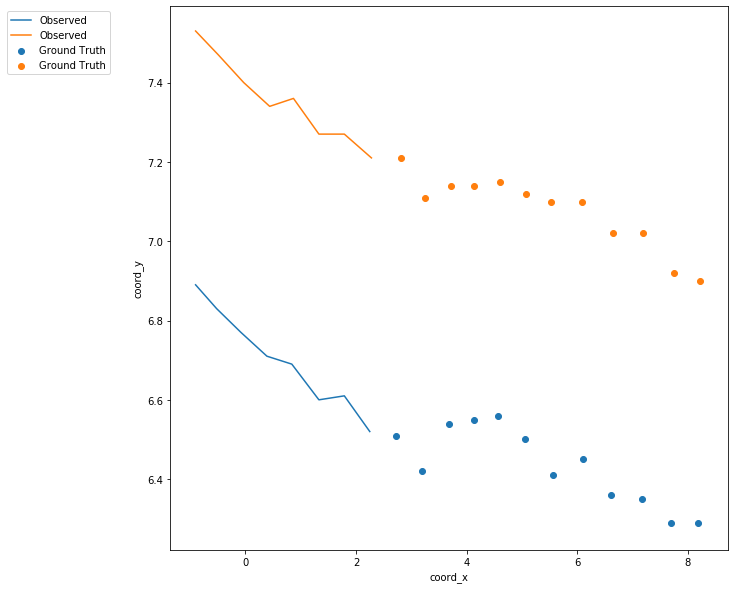

65


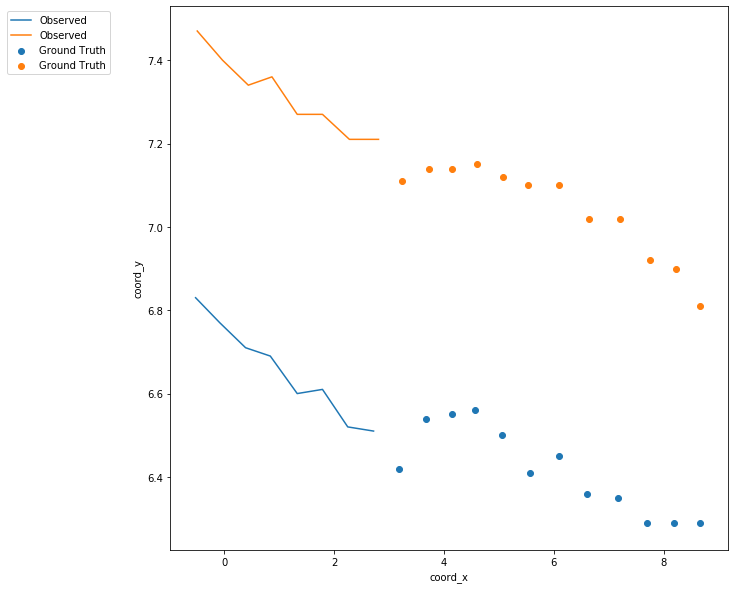

66


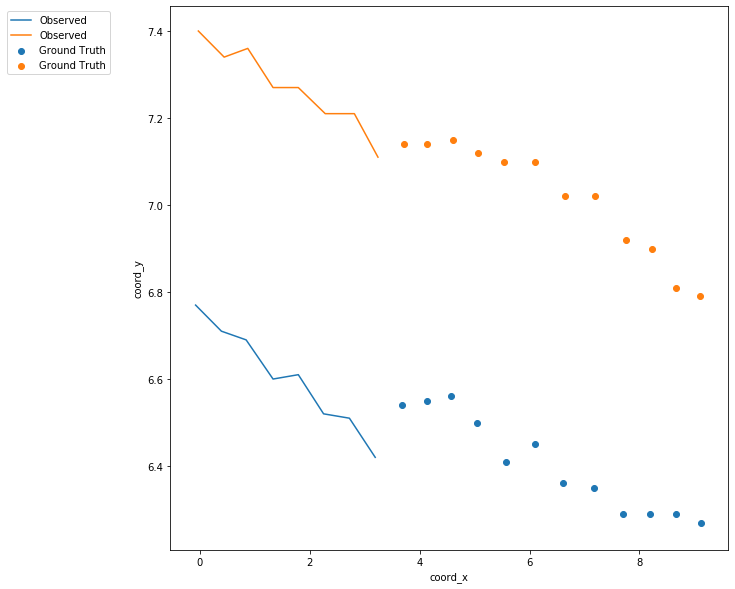

67


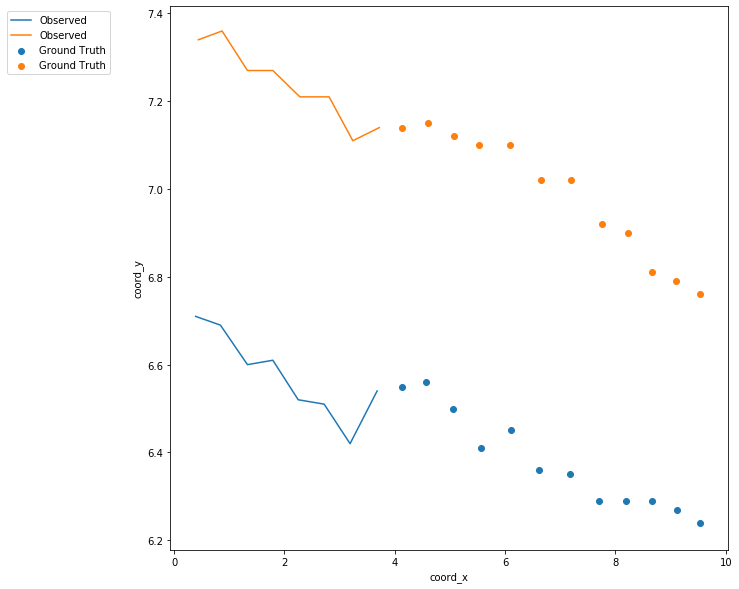

68


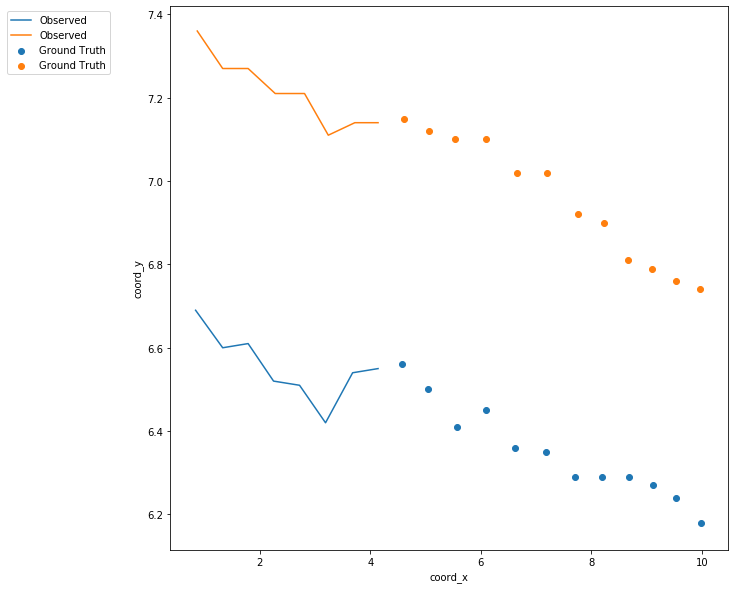

69


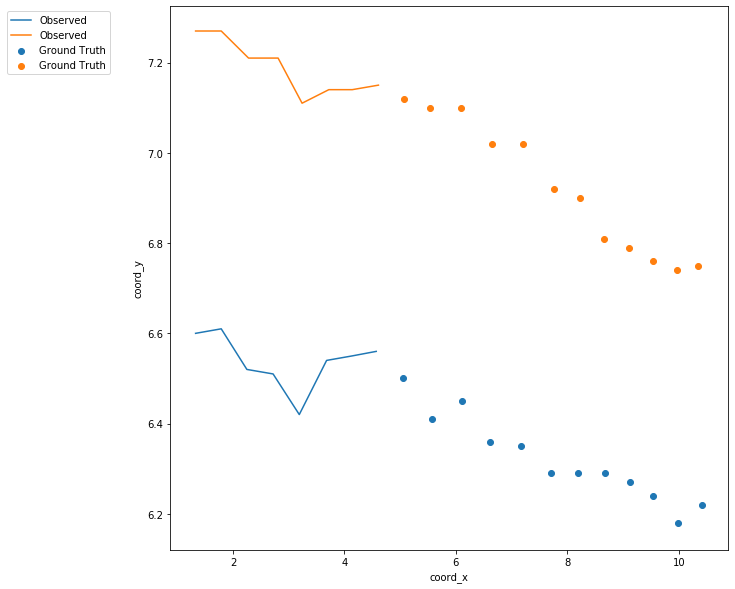

In [194]:
for cnt,batch in enumerate(loader_test):
    batch = [tensor.to(device) for tensor in batch]
    obs_traj, \
    pred_traj_gt,\
    obs_traj_rel, \
    pred_traj_gt_rel, \
    non_linear_ped,\
    loss_mask,\
    V_obs,\
    A_obs,\
    V_tr,\
    A_tr = batch
#     print(obs_traj)
#     print(obs_traj.shape)
#     G = nx.from_numpy_matrix(A_obs[0,1,:,:].numpy())
#     print(A_obs[0,1,:,:])
#     nx.draw(G)
# V_pred = model(V_obs,A_obs)
    print(cnt)
    plot_trajs(obs_traj.detach().cpu().numpy(),pred_traj_gt.detach().cpu().numpy())
# plot_traj(V_pred_to_trajectory(V_tr, obs_traj))

In [65]:
print(raw_data_dic_[1]['obs'].shape)
for p,v in ade_all.items():
    print(p,len(v))

(8, 2, 2)
0 20
1 20


In [57]:
print(obs_traj.shape)

torch.Size([1, 5, 2, 8])
